In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import numpy as np
from PIL import Image
import cv2
import matplotlib.image as mpimg
import os
import scipy.ndimage as ndimage
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 30

In [39]:
#importing dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "images",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2273 files belonging to 10 classes.


In [14]:
#display dataset classes
class_names = dataset.class_names
class_names

['guava_diseased',
 'guava_healthy',
 'jamun_diseased',
 'jamun_healthy',
 'lemon_diseased',
 'lemon_healthy',
 'mango_diseased',
 'mango_healthy',
 'pomegranate_diseased',
 'pomegrenate_healthy']

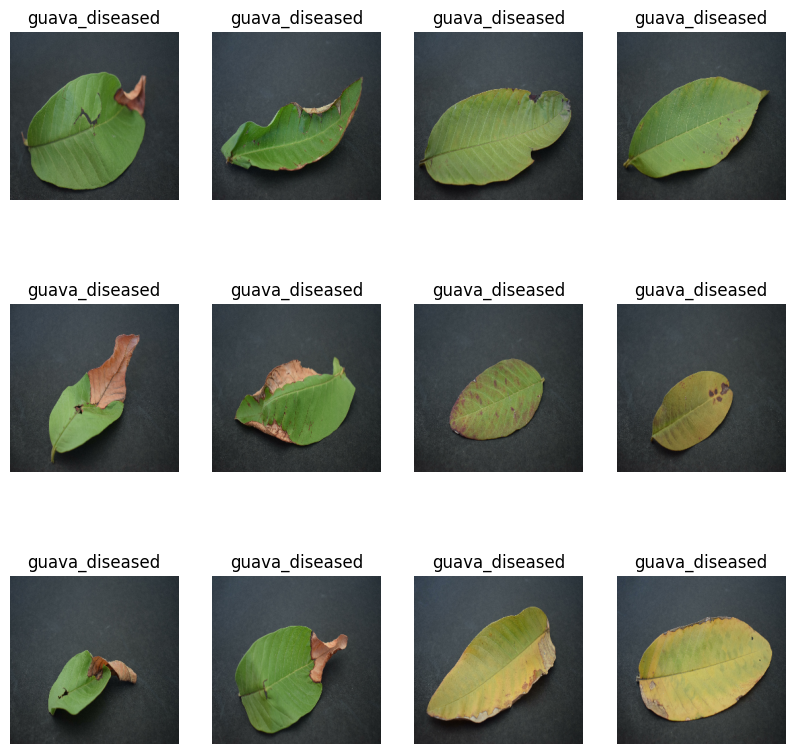

In [11]:
# Display Images

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [39]:
len(dataset)

72

In [40]:
train_size = 0.8
len(dataset)*train_size

57.6

In [41]:
train_ds = dataset.take(57)
len(train_ds)

57

In [42]:
test_ds = dataset.skip(57)
len(test_ds)

15

In [43]:
val_size=0.1
len(dataset)*val_size

7.2

In [44]:
val_ds = test_ds.take(7)
len(val_ds)

7

In [45]:
test_ds = test_ds.skip(7)
len(test_ds)

8

In [48]:
#dataset partition

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [48]:
len(dataset)

72

In [49]:
len(train_ds)

57

In [50]:
len(val_ds)

7

In [51]:
len(test_ds)

8

In [49]:
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
#image resizing and rescaling
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [54]:
normalized_dataset = dataset.map(lambda x, y: (resize_and_rescale(x), y))

In [55]:
for images, labels in normalized_dataset:
    for image in images:
        print(image)

tf.Tensor(
[[[0.13429075 0.1656633  0.177428  ]
  [0.14602482 0.17739737 0.18916208]
  [0.13688727 0.16825981 0.18002452]
  ...
  [0.11543352 0.14288451 0.16641392]
  [0.12843138 0.15588236 0.17941177]
  [0.11321232 0.14066331 0.16419272]]

 [[0.13217679 0.16354933 0.17531404]
  [0.15225185 0.1836244  0.1953891 ]
  [0.14460786 0.1759804  0.18774511]
  ...
  [0.13325675 0.16070773 0.18423714]
  [0.12965687 0.15710786 0.18063727]
  [0.13284315 0.16029413 0.18382354]]

 [[0.13063726 0.16200982 0.17377453]
  [0.11713389 0.14850645 0.16027115]
  [0.13504903 0.16642158 0.17818628]
  ...
  [0.13096662 0.1584176  0.18194701]
  [0.12661612 0.1540671  0.17759652]
  [0.11727176 0.14472274 0.16825216]]

 ...

 [[0.12892158 0.12892158 0.13676472]
  [0.125      0.125      0.13284315]
  [0.11801472 0.11801472 0.12585784]
  ...
  [0.1134804  0.1134804  0.12132353]
  [0.12048867 0.12048867 0.12833181]
  [0.10550705 0.10550705 0.11335019]]

 [[0.13014707 0.13014707 0.1379902 ]
  [0.12156864 0.12156864 0

tf.Tensor(
[[[0.06877298 0.08053769 0.10014553]
  [0.06586244 0.07762715 0.09723499]
  [0.07695313 0.09656098 0.11224725]
  ...
  [0.05343138 0.06519608 0.08480392]
  [0.06451441 0.08020068 0.09196538]
  [0.05343138 0.06911765 0.08088236]]

 [[0.06691177 0.08259805 0.09436275]
  [0.0884421  0.10020681 0.11981465]
  [0.06688879 0.0786535  0.09826134]
  ...
  [0.05539216 0.06715687 0.08676471]
  [0.06531863 0.08100491 0.09276962]
  [0.06642158 0.08210785 0.09387255]]

 [[0.07843138 0.09019608 0.10980393]
  [0.07450981 0.08627451 0.10588236]
  [0.07058824 0.08235294 0.10196079]
  ...
  [0.05882353 0.07450981 0.08627451]
  [0.0627451  0.07843138 0.09019608]
  [0.05968137 0.07536765 0.08713236]]

 ...

 [[0.07144608 0.06360295 0.07536765]
  [0.07058824 0.0627451  0.07450981]
  [0.07430301 0.06645987 0.07822458]
  ...
  [0.06666667 0.05882353 0.07058824]
  [0.07671569 0.06887256 0.08063726]
  [0.06666667 0.05882353 0.07058824]]

 [[0.07401961 0.06617647 0.07794118]
  [0.06691177 0.05906863 0

tf.Tensor(
[[[0.12181373 0.20416668 0.28651962]
  [0.14248621 0.22483917 0.29934898]
  [0.14020374 0.2225567  0.2970665 ]
  ...
  [0.11887255 0.1894608  0.26789218]
  [0.13287379 0.20346202 0.2818934 ]
  [0.1384804  0.19730394 0.2796569 ]]

 [[0.14117648 0.22352943 0.29803923]
  [0.13700981 0.21936275 0.29387257]
  [0.15257354 0.23492648 0.3094363 ]
  ...
  [0.11784621 0.18843445 0.26686582]
  [0.12022059 0.19080883 0.2692402 ]
  [0.13529412 0.19411767 0.2764706 ]]

 [[0.13554688 0.21789983 0.29240963]
  [0.14997703 0.23232998 0.3068398 ]
  [0.14583334 0.2281863  0.3026961 ]
  ...
  [0.13161765 0.2022059  0.28063726]
  [0.13284315 0.20343138 0.28186277]
  [0.11936275 0.18995099 0.26838237]]

 ...

 [[0.10196079 0.12156864 0.14509805]
  [0.10492495 0.12453279 0.1480622 ]
  [0.11180301 0.13141085 0.15494026]
  ...
  [0.09375001 0.11335785 0.12904413]
  [0.0884804  0.10808824 0.12377451]
  [0.08836551 0.10013022 0.11973806]]

 [[0.09803922 0.1137255  0.14901961]
  [0.08827359 0.10395987 0

tf.Tensor(
[[[0.14793965 0.1675475  0.1793122 ]
  [0.16087623 0.18048409 0.19224879]
  [0.15001532 0.16962317 0.18530944]
  ...
  [0.12120099 0.13688727 0.14865197]
  [0.10563726 0.12132353 0.13308825]
  [0.12193628 0.13762255 0.14938727]]

 [[0.15509345 0.1747013  0.18646601]
  [0.14525889 0.16486673 0.17663145]
  [0.13024664 0.14985448 0.16554075]
  ...
  [0.1103937  0.12607998 0.13784468]
  [0.11384805 0.12953432 0.13345589]
  [0.09737286 0.11305913 0.12482385]]

 [[0.1433747  0.16298255 0.17474726]
  [0.13982844 0.15943629 0.17120099]
  [0.15518537 0.17479321 0.18655792]
  ...
  [0.11319701 0.12888327 0.13280486]
  [0.1223269  0.13801318 0.14193475]
  [0.11936275 0.13504903 0.1389706 ]]

 ...

 [[0.10759804 0.10367648 0.12328432]
  [0.1221584  0.11823683 0.13784468]
  [0.11764707 0.11764707 0.1254902 ]
  ...
  [0.11764707 0.11764707 0.1254902 ]
  [0.10083487 0.10083487 0.10867801]
  [0.11200981 0.11200981 0.11985295]]

 [[0.11452972 0.11060815 0.130216  ]
  [0.12005975 0.11613818 0

tf.Tensor(
[[[0.20670956 0.23416056 0.25768995]
  [0.2085095  0.2359605  0.2594899 ]
  [0.19984682 0.22729781 0.25082722]
  ...
  [0.17254902 0.20000002 0.22352943]
  [0.17621018 0.20366116 0.22719058]
  [0.18327972 0.21073072 0.23426013]]

 [[0.19149052 0.22678463 0.24639247]
  [0.2029029  0.23035388 0.25388327]
  [0.1990426  0.22649358 0.250023  ]
  ...
  [0.18174021 0.20919119 0.2327206 ]
  [0.15833335 0.18578433 0.20931374]
  [0.19196539 0.21941638 0.24294579]]

 [[0.22010571 0.24755669 0.2710861 ]
  [0.19463083 0.22992495 0.2495328 ]
  [0.20392159 0.2392157  0.25882354]
  ...
  [0.16895682 0.1964078  0.2199372 ]
  [0.17512256 0.20257354 0.22610295]
  [0.17255668 0.20000768 0.22353709]]

 ...

 [[0.19398744 0.19398744 0.20183058]
  [0.1947304  0.21041667 0.22218138]
  [0.19440106 0.21008733 0.22185203]
  ...
  [0.15199909 0.15199909 0.15984222]
  [0.15637256 0.15637256 0.1642157 ]
  [0.1834559  0.1834559  0.19129904]]

 [[0.18965228 0.18965228 0.19749542]
  [0.19289216 0.1889706  0

tf.Tensor(
[[[0.19943322 0.24649204 0.30139402]
  [0.20866269 0.2557215  0.3106235 ]
  [0.20761336 0.2546722  0.30957416]
  ...
  [0.16337317 0.21435356 0.24964769]
  [0.17444088 0.22542128 0.2607154 ]
  [0.18561582 0.23659621 0.27189034]]

 [[0.20000002 0.24705884 0.3019608 ]
  [0.19816178 0.2452206  0.30012256]
  [0.1878217  0.23488052 0.2897825 ]
  ...
  [0.18801318 0.22722888 0.26644456]
  [0.18165596 0.23263635 0.26793048]
  [0.16384804 0.21482845 0.25012258]]

 [[0.18430607 0.2313649  0.28626686]
  [0.18988205 0.23694089 0.29184285]
  [0.19705884 0.24411766 0.29901963]
  ...
  [0.17548254 0.21077667 0.2696002 ]
  [0.16191024 0.20112593 0.24034162]
  [0.16469823 0.21175706 0.26665902]]

 ...

 [[0.14031863 0.13639706 0.1560049 ]
  [0.14558825 0.14166668 0.16127452]
  [0.18496478 0.18104321 0.20065105]
  ...
  [0.10625    0.12193628 0.13370098]
  [0.11507354 0.1307598  0.13468137]
  [0.10464921 0.12033548 0.1321002 ]]

 [[0.12764247 0.1237209  0.14332874]
  [0.16262256 0.15870099 0

tf.Tensor(
[[[0.14076288 0.17997856 0.21919425]
  [0.13524051 0.1744562  0.2136719 ]
  [0.13537838 0.17459406 0.21380976]
  ...
  [0.12106312 0.15635724 0.18380822]
  [0.12110908 0.1564032  0.18385418]
  [0.09793965 0.13323377 0.16068475]]

 [[0.13683365 0.17604934 0.21526502]
  [0.1557981  0.19501379 0.23422949]
  [0.1483073  0.18752299 0.22673868]
  ...
  [0.10921416 0.14450829 0.17195927]
  [0.10220589 0.1375     0.164951  ]
  [0.09828432 0.13357843 0.16102943]]

 [[0.13762255 0.17683825 0.21605393]
  [0.15884651 0.19806221 0.2372779 ]
  [0.13578433 0.17500001 0.2142157 ]
  ...
  [0.10339309 0.13868721 0.16613819]
  [0.09622397 0.13151808 0.15896906]
  [0.10980393 0.14509805 0.17254902]]

 ...

 [[0.07450981 0.06666667 0.07843138]
  [0.07450981 0.06666667 0.07843138]
  [0.09362745 0.08578432 0.09754903]
  ...
  [0.07095589 0.07095589 0.07879902]
  [0.07058824 0.07058824 0.07843138]
  [0.05795803 0.05795803 0.06580117]]

 [[0.07555913 0.067716   0.0794807 ]
  [0.08210785 0.07426471 0

tf.Tensor(
[[[0.21213236 0.26311275 0.32585785]
  [0.19287685 0.24385725 0.30660236]
  [0.19338237 0.24436276 0.30710787]
  ...
  [0.19226411 0.26285234 0.3412837 ]
  [0.17687654 0.24746478 0.32589617]
  [0.18537073 0.25595897 0.33439034]]

 [[0.18125    0.23223041 0.29497552]
  [0.1769608  0.22794119 0.29068628]
  [0.18112746 0.23210786 0.29485297]
  ...
  [0.18762256 0.2582108  0.33664218]
  [0.16454504 0.23513329 0.31356466]
  [0.17958795 0.2501762  0.32860756]]

 [[0.19397213 0.24495253 0.30769762]
  [0.19400276 0.24498317 0.30772826]
  [0.19166668 0.24264707 0.30539218]
  ...
  [0.18709406 0.2576823  0.3361137 ]
  [0.19289216 0.2634804  0.3419118 ]
  [0.19473806 0.2653263  0.3437577 ]]

 ...

 [[0.10932139 0.10539982 0.12500767]
  [0.12242648 0.11850491 0.13811275]
  [0.11764707 0.11764707 0.1254902 ]
  ...
  [0.12818629 0.13995099 0.15955883]
  [0.12661612 0.13838083 0.15798867]
  [0.11200981 0.12377451 0.14338236]]

 [[0.11251532 0.10859375 0.1282016 ]
  [0.11503524 0.11503524 0

tf.Tensor(
[[[0.14963236 0.19669119 0.25159314]
  [0.15499388 0.20205271 0.25695467]
  [0.173966   0.22102483 0.28376994]
  ...
  [0.1254902  0.16470589 0.20392159]
  [0.14276962 0.1819853  0.21727942]
  [0.12097887 0.16019456 0.19548868]]

 [[0.16808365 0.21514247 0.27004445]
  [0.15690105 0.21180302 0.2627834 ]
  [0.14928769 0.20026809 0.26301318]
  ...
  [0.1226486  0.16186428 0.20107998]
  [0.13308825 0.17230393 0.20759805]
  [0.11819088 0.15740657 0.19662225]]

 [[0.16299021 0.21004903 0.264951  ]
  [0.15906864 0.2139706  0.264951  ]
  [0.15265779 0.20755975 0.25854015]
  ...
  [0.13602942 0.1752451  0.21446079]
  [0.13956036 0.17093292 0.21407017]
  [0.13172488 0.17094058 0.2062347 ]]

 ...

 [[0.1014706  0.12107844 0.14460786]
  [0.11715687 0.13676472 0.16029413]
  [0.10735295 0.1269608  0.15049021]
  ...
  [0.09950981 0.11127452 0.13088237]
  [0.10269608 0.11446079 0.13406864]
  [0.10808824 0.11985295 0.13946079]]

 [[0.11004902 0.12965687 0.15318628]
  [0.10612746 0.1257353  0

tf.Tensor(
[[[0.0878217  0.10742954 0.11919425]
  [0.09509805 0.11470589 0.1264706 ]
  [0.08849572 0.10810356 0.12378984]
  ...
  [0.06642158 0.09779412 0.10955883]
  [0.06906404 0.10043658 0.1122013 ]
  [0.0625     0.09387255 0.10563726]]

 [[0.08933824 0.10894608 0.12463236]
  [0.10302544 0.12263328 0.13831955]
  [0.0853171  0.10492495 0.12061122]
  ...
  [0.07877605 0.11014859 0.12191331]
  [0.08161765 0.1129902  0.12475491]
  [0.07144608 0.10281863 0.11458334]]

 [[0.0884804  0.10808824 0.12377451]
  [0.0762255  0.09583334 0.11151961]
  [0.07908242 0.11045497 0.12221967]
  ...
  [0.07116269 0.10253524 0.11429995]
  [0.07450981 0.10588236 0.11764707]
  [0.07757353 0.10894608 0.12071079]]

 ...

 [[0.08713236 0.08321079 0.10281863]
  [0.08762255 0.08370098 0.10330883]
  [0.08063726 0.07671569 0.1002451 ]
  ...
  [0.07230393 0.06838236 0.0879902 ]
  [0.07671569 0.07279412 0.09240197]
  [0.06666667 0.0627451  0.08235294]]

 [[0.08627451 0.08235294 0.10196079]
  [0.07708333 0.07316177 0

tf.Tensor(
[[[0.20612746 0.25710785 0.31985295]
  [0.19388787 0.24486828 0.30761337]
  [0.2034467  0.2544271  0.3171722 ]
  ...
  [0.16554075 0.21652116 0.28318784]
  [0.17801778 0.22899817 0.29566485]
  [0.164951   0.21593139 0.27867648]]

 [[0.20392159 0.25490198 0.31764707]
  [0.19713543 0.24811582 0.31086093]
  [0.20418966 0.25517005 0.31791514]
  ...
  [0.17624848 0.22722888 0.29389554]
  [0.16200982 0.21299021 0.2796569 ]
  [0.16556373 0.21654414 0.27928925]]

 [[0.19253218 0.24351257 0.30625767]
  [0.21392465 0.26490504 0.32765013]
  [0.20183824 0.25281864 0.31556374]
  ...
  [0.17254902 0.22352943 0.2901961 ]
  [0.15379903 0.20477943 0.2714461 ]
  [0.16960785 0.22058825 0.28333336]]

 ...

 [[0.14596355 0.14204198 0.16164982]
  [0.13725491 0.13333334 0.15294118]
  [0.14779413 0.14387256 0.1634804 ]
  ...
  [0.1196921  0.1314568  0.15106465]
  [0.11296722 0.12473193 0.14433977]
  [0.1137255  0.13333334 0.14901961]]

 [[0.1442402  0.14031863 0.15992647]
  [0.14485295 0.14093138 0

tf.Tensor(
[[[0.0918122  0.11926318 0.1427926 ]
  [0.09466147 0.12211245 0.14564186]
  [0.09277727 0.12022825 0.14375767]
  ...
  [0.0759804  0.11127452 0.13088237]
  [0.07408854 0.10938267 0.12899052]
  [0.08504903 0.1125     0.13602942]]

 [[0.08216146 0.10961244 0.13314186]
  [0.08394609 0.11139707 0.13492648]
  [0.08284314 0.11029413 0.13382354]
  ...
  [0.07426471 0.10955883 0.12916668]
  [0.08488052 0.12017464 0.13978249]
  [0.07395068 0.1092448  0.12885264]]

 [[0.09546569 0.12291668 0.1464461 ]
  [0.08808977 0.11554076 0.13907017]
  [0.08750001 0.11495098 0.1384804 ]
  ...
  [0.07307751 0.10837164 0.12797949]
  [0.07058824 0.10588236 0.1254902 ]
  [0.08014707 0.11544118 0.13504903]]

 ...

 [[0.07547488 0.09116115 0.10292587]
  [0.08627451 0.08235294 0.10196079]
  [0.0879902  0.08406863 0.10367648]
  ...
  [0.08235294 0.07843138 0.09803922]
  [0.06225491 0.05833334 0.07794118]
  [0.08455883 0.08063726 0.1002451 ]]

 [[0.07450981 0.07058824 0.09019608]
  [0.0821921  0.07827053 0

tf.Tensor(
[[[0.18250614 0.25701594 0.31583947]
  [0.19581802 0.27032784 0.32915136]
  [0.20917587 0.28368568 0.3425092 ]
  ...
  [0.18088236 0.24362746 0.30637255]
  [0.17807905 0.24082416 0.30356926]
  [0.1694853  0.23223041 0.29497552]]

 [[0.18406864 0.25857845 0.31740198]
  [0.17038144 0.24489126 0.30371478]
  [0.17171417 0.24622397 0.3050475 ]
  ...
  [0.19803923 0.26078433 0.32352942]
  [0.18537839 0.24812348 0.3108686 ]
  [0.18210785 0.24485296 0.30759805]]

 [[0.1925475  0.2670573  0.32588083]
  [0.18174021 0.25625002 0.31507355]
  [0.1887255  0.2632353  0.32205886]
  ...
  [0.18504903 0.24779414 0.31053925]
  [0.18651962 0.24926472 0.3120098 ]
  [0.18382354 0.24656864 0.30931374]]

 ...

 [[0.15906864 0.18651962 0.21004903]
  [0.16492802 0.192379   0.21590841]
  [0.15808825 0.18553923 0.20906864]
  ...
  [0.100697   0.11638328 0.12030485]
  [0.11102942 0.12671569 0.13063726]
  [0.1014706  0.11715687 0.12107844]]

 [[0.16512716 0.19257814 0.21610755]
  [0.13378525 0.16123623 0

tf.Tensor(
[[[0.13684131 0.18390013 0.24664524]
  [0.14749542 0.18278953 0.2494562 ]
  [0.14019608 0.1754902  0.24215688]
  ...
  [0.13138022 0.1705959  0.20589003]
  [0.12709866 0.16239278 0.1976869 ]
  [0.13069087 0.165985   0.20127912]]

 [[0.141682   0.18874082 0.2514859 ]
  [0.14918046 0.18447459 0.25114125]
  [0.1416437  0.17693782 0.24360448]
  ...
  [0.1259804  0.16519609 0.2004902 ]
  [0.12516086 0.16437654 0.19967066]
  [0.12806374 0.16335785 0.19865197]]

 [[0.13945313 0.18651196 0.24925706]
  [0.13191637 0.16721049 0.23387715]
  [0.13583028 0.1711244  0.23779106]
  ...
  [0.12797949 0.1632736  0.19856772]
  [0.11119793 0.15041362 0.18570773]
  [0.12414216 0.16335785 0.19865197]]

 ...

 [[0.08417586 0.08025429 0.09986214]
  [0.09019608 0.09019608 0.09803922]
  [0.0942402  0.0942402  0.10208334]
  ...
  [0.07058824 0.07058824 0.07843138]
  [0.06666667 0.06666667 0.07450981]
  [0.05968137 0.05968137 0.06752452]]

 [[0.09411766 0.08627451 0.09803922]
  [0.08578432 0.08578432 0

tf.Tensor(
[[[0.17105547 0.20634958 0.2416437 ]
  [0.15795037 0.1932445  0.22853862]
  [0.17170651 0.20700063 0.24229474]
  ...
  [0.1454657  0.18075982 0.21605393]
  [0.14264707 0.17794119 0.2132353 ]
  [0.13865657 0.17395069 0.2092448 ]]

 [[0.17706802 0.21236214 0.24765627]
  [0.1880285  0.22332263 0.25861675]
  [0.177428   0.21272214 0.24801625]
  ...
  [0.14154413 0.17683825 0.21213236]
  [0.13582262 0.17111674 0.20641086]
  [0.14459254 0.17988665 0.21518077]]

 [[0.15503983 0.19425553 0.22954965]
  [0.1694853  0.20477943 0.24007355]
  [0.17867649 0.2139706  0.24926472]
  ...
  [0.1447304  0.18002452 0.21531864]
  [0.14203432 0.17732844 0.21262257]
  [0.14203432 0.17732844 0.21262257]]

 ...

 [[0.11286765 0.11286765 0.12071079]
  [0.11725644 0.1094133  0.12117801]
  [0.12156864 0.1137255  0.1254902 ]
  ...
  [0.12148438 0.12148438 0.12932752]
  [0.11066177 0.11066177 0.11850491]
  [0.10980393 0.10980393 0.11764707]]

 [[0.09828432 0.09828432 0.10612746]
  [0.10563726 0.10563726 0

tf.Tensor(
[[[0.10806526 0.1276731  0.13943781]
  [0.11759345 0.1372013  0.148966  ]
  [0.10343138 0.12303922 0.13480394]
  ...
  [0.10317862 0.11886489 0.12278646]
  [0.09264706 0.10833334 0.11225491]
  [0.09252451 0.10821079 0.11213236]]

 [[0.12083334 0.14044118 0.15220588]
  [0.10457262 0.12418046 0.13594517]
  [0.11776961 0.13737746 0.14914216]
  ...
  [0.07845435 0.09414063 0.0980622 ]
  [0.09644608 0.1199755  0.1199755 ]
  [0.09644608 0.11213236 0.11605393]]

 [[0.10245099 0.12205883 0.13382354]
  [0.09803922 0.11764707 0.12941177]
  [0.10980393 0.12941177 0.14117648]
  ...
  [0.10751379 0.12320007 0.12712164]
  [0.09019608 0.10588236 0.10980393]
  [0.09804688 0.11373316 0.11765473]]

 ...

 [[0.10196079 0.08627451 0.09019608]
  [0.10002299 0.09217985 0.09610142]
  [0.09019608 0.08235294 0.08627451]
  ...
  [0.07058824 0.07058824 0.07058824]
  [0.07509957 0.07509957 0.08294272]
  [0.06800705 0.06800705 0.07585019]]

 [[0.1029565  0.08727022 0.09119179]
  [0.11331955 0.09763328 0

tf.Tensor(
[[[0.20112593 0.29132202 0.36191025]
  [0.20071998 0.2909161  0.36150432]
  [0.21161154 0.29396448 0.36847427]
  ...
  [0.16826747 0.23101257 0.29375768]
  [0.16187194 0.22069548 0.2952053 ]
  [0.15886949 0.2216146  0.2843597 ]]

 [[0.18602942 0.2762255  0.34681374]
  [0.1903263  0.28052238 0.3511106 ]
  [0.18933825 0.2716912  0.346201  ]
  ...
  [0.16911766 0.23186275 0.29460785]
  [0.17079505 0.22961858 0.30412838]
  [0.16813727 0.23088236 0.29362747]]

 [[0.19350491 0.283701   0.35428923]
  [0.20257354 0.2927696  0.36335787]
  [0.21041667 0.2927696  0.36727944]
  ...
  [0.157307   0.2200521  0.2827972 ]
  [0.16740197 0.23014708 0.2928922 ]
  [0.1703508  0.23309591 0.295841  ]]

 ...

 [[0.10282629 0.12243414 0.13812041]
  [0.10563726 0.12524511 0.14093138]
  [0.10996477 0.12957262 0.14525889]
  ...
  [0.06838236 0.08406863 0.09583334]
  [0.08304229 0.09872856 0.11049327]
  [0.07843138 0.09411766 0.10588236]]

 [[0.10612746 0.1257353  0.14142157]
  [0.10196079 0.12156864 0

tf.Tensor(
[[[0.14536612 0.22771907 0.30222887]
  [0.1287454  0.19933365 0.27776504]
  [0.11898745 0.19349726 0.26016393]
  ...
  [0.14329045 0.18250614 0.22172183]
  [0.13063726 0.16985296 0.20906864]
  [0.13480394 0.17401962 0.2132353 ]]

 [[0.16360295 0.2459559  0.3204657 ]
  [0.15379903 0.23615198 0.3106618 ]
  [0.14068629 0.21127452 0.2897059 ]
  ...
  [0.12048867 0.17146906 0.2067632 ]
  [0.13909315 0.17830883 0.21752453]
  [0.14791667 0.18713236 0.22634806]]

 [[0.15589002 0.23824297 0.32059592]
  [0.17024358 0.25259653 0.33494946]
  [0.1502068  0.23255976 0.3149127 ]
  ...
  [0.14080884 0.19178922 0.22708334]
  [0.1286535  0.1796339  0.21492802]
  [0.1307598  0.1699755  0.20919119]]

 ...

 [[0.07585785 0.06801471 0.08762255]
  [0.07450981 0.06666667 0.08627451]
  [0.07606465 0.06822151 0.08782936]
  ...
  [0.06715687 0.06715687 0.075     ]
  [0.07058824 0.07058824 0.07843138]
  [0.06580883 0.06580883 0.07365196]]

 [[0.06666667 0.05882353 0.07843138]
  [0.07058824 0.0627451  0

tf.Tensor(
[[[0.20880057 0.25978097 0.32252607]
  [0.20257354 0.2574755  0.3084559 ]
  [0.2204657  0.27536768 0.32634807]
  ...
  [0.19336705 0.24042587 0.29532784]
  [0.16164216 0.208701   0.26360294]
  [0.17277882 0.21983764 0.2747396 ]]

 [[0.21568629 0.27058825 0.32156864]
  [0.22806373 0.2829657  0.3339461 ]
  [0.21225491 0.26715687 0.3181373 ]
  ...
  [0.18120405 0.22826289 0.28316486]
  [0.18530178 0.23236062 0.2872626 ]
  [0.19453892 0.24159774 0.2964997 ]]

 [[0.21188727 0.26286766 0.32561275]
  [0.21409315 0.2689951  0.3199755 ]
  [0.2255668  0.28046876 0.33144915]
  ...
  [0.19807753 0.24513635 0.3000383 ]
  [0.18661919 0.23367801 0.28857997]
  [0.18308058 0.23013942 0.2850414 ]]

 ...

 [[0.13063726 0.14632353 0.15808825]
  [0.13333334 0.14901961 0.16078432]
  [0.16768536 0.18337165 0.19513635]
  ...
  [0.12120099 0.13688727 0.14865197]
  [0.12828586 0.14397213 0.15573683]
  [0.13419119 0.14987746 0.16164216]]

 [[0.16745558 0.16353402 0.18706343]
  [0.15428923 0.1699755  0

tf.Tensor(
[[[0.20634958 0.29654565 0.36713392]
  [0.21741728 0.29977024 0.37428004]
  [0.22364432 0.30599725 0.38050708]
  ...
  [0.20526196 0.26800707 0.33075216]
  [0.20231313 0.26505822 0.3278033 ]
  [0.1992877  0.2620328  0.3247779 ]]

 [[0.19166668 0.27401963 0.34852943]
  [0.21911766 0.3014706  0.3759804 ]
  [0.23909315 0.3214461  0.39595592]
  ...
  [0.20034468 0.26308978 0.32583487]
  [0.1906097  0.2533548  0.31609988]
  [0.17904413 0.24178924 0.30453435]]

 [[0.21433824 0.29669118 0.371201  ]
  [0.235095   0.31744793 0.39195773]
  [0.2265089  0.30886185 0.38337165]
  ...
  [0.20248929 0.26523438 0.3279795 ]
  [0.20563726 0.26838237 0.33112746]
  [0.18651196 0.24925706 0.31200215]]

 ...

 [[0.12254903 0.14215687 0.15784314]
  [0.12902115 0.148629   0.1721584 ]
  [0.14607844 0.16568628 0.1892157 ]
  ...
  [0.09975491 0.11544118 0.11936275]
  [0.11419272 0.129879   0.13380057]
  [0.09019608 0.10588236 0.10980393]]

 [[0.12071079 0.14031863 0.1560049 ]
  [0.12941177 0.14901961 0

tf.Tensor(
[[[0.11318935 0.16416974 0.19946386]
  [0.12652421 0.1775046  0.21279873]
  [0.12107844 0.16813727 0.22303922]
  ...
  [0.0826057  0.12182139 0.15711552]
  [0.09142157 0.13063726 0.16593139]
  [0.08632813 0.12554382 0.16083793]]

 [[0.11985295 0.17083335 0.20612746]
  [0.11911765 0.16617648 0.22107844]
  [0.1291437  0.17620252 0.2311045 ]
  ...
  [0.0904182  0.12963389 0.16492802]
  [0.09019608 0.12941177 0.16470589]
  [0.0947304  0.13394609 0.1692402 ]]

 [[0.10979627 0.15685509 0.21175706]
  [0.11742494 0.16448377 0.21938574]
  [0.11727942 0.16433825 0.2192402 ]
  ...
  [0.10196079 0.14117648 0.1764706 ]
  [0.09316024 0.13237593 0.16767004]
  [0.09374235 0.13295804 0.16825216]]

 ...

 [[0.08762255 0.11507354 0.1464461 ]
  [0.0879902  0.11544118 0.14681374]
  [0.08627451 0.1137255  0.14509805]
  ...
  [0.07814799 0.09775583 0.12128524]
  [0.08911612 0.10872397 0.13225338]
  [0.08627451 0.10588236 0.12941177]]

 [[0.09008885 0.11753984 0.14891239]
  [0.09620099 0.12365197 0

tf.Tensor(
[[[0.08478095 0.10046723 0.11223193]
  [0.09208793 0.10777421 0.11953892]
  [0.07709866 0.09278493 0.10454964]
  ...
  [0.08101257 0.09277727 0.11238512]
  [0.08426011 0.10386796 0.11955424]
  [0.07296263 0.09257047 0.10825675]]

 [[0.07034314 0.08602942 0.09779412]
  [0.07209712 0.0877834  0.09954811]
  [0.08235294 0.09803922 0.10980393]
  ...
  [0.07179075 0.08355546 0.1031633 ]
  [0.07463235 0.0942402  0.10992648]
  [0.07757353 0.09718138 0.11286765]]

 [[0.08541667 0.10110295 0.11286765]
  [0.08100491 0.09669118 0.10845589]
  [0.09240197 0.10808824 0.11985295]
  ...
  [0.08014707 0.09191177 0.11151961]
  [0.06973039 0.08933824 0.10502452]
  [0.07107843 0.09068628 0.10637256]]

 ...

 [[0.0884804  0.08063726 0.09240197]
  [0.09335938 0.08551624 0.09728095]
  [0.08341759 0.07557445 0.08733916]
  ...
  [0.07450981 0.06666667 0.08627451]
  [0.07450981 0.07450981 0.08235294]
  [0.07096355 0.07096355 0.07880668]]

 [[0.09019608 0.08235294 0.09411766]
  [0.10310203 0.09525889 0

tf.Tensor(
[[[0.19744946 0.24842985 0.31117496]
  [0.18072918 0.24347427 0.3022978 ]
  [0.19975491 0.26250002 0.32132354]
  ...
  [0.195504   0.27785695 0.35236675]
  [0.17120099 0.25355393 0.32806376]
  [0.18943782 0.27179077 0.34630057]]

 [[0.1816866  0.24443169 0.30325523]
  [0.1827206  0.2454657  0.30428922]
  [0.18088236 0.24362746 0.30245098]
  ...
  [0.1957108  0.27806374 0.35257354]
  [0.19350491 0.27585787 0.35036767]
  [0.18737747 0.26973042 0.34424022]]

 [[0.18602942 0.24877453 0.30759805]
  [0.17583488 0.23857997 0.2974035 ]
  [0.20420498 0.26695007 0.3257736 ]
  ...
  [0.18182446 0.2641774  0.3386872 ]
  [0.18409161 0.26644456 0.34095436]
  [0.18909314 0.2714461  0.3459559 ]]

 ...

 [[0.09546569 0.09546569 0.10330883]
  [0.11889553 0.11889553 0.12673867]
  [0.10759804 0.10759804 0.11544118]
  ...
  [0.10894608 0.12071079 0.14031863]
  [0.12281711 0.1345818  0.15418966]
  [0.11066177 0.12242648 0.14203432]]

 [[0.11433824 0.11433824 0.12218138]
  [0.11188726 0.11188726 0

tf.Tensor(
[[[0.17144608 0.20281863 0.2459559 ]
  [0.16344976 0.19482231 0.23795958]
  [0.1725337  0.20390627 0.24704352]
  ...
  [0.15281864 0.19987746 0.26262257]
  [0.14620098 0.19325982 0.25600493]
  [0.1487975  0.19585632 0.25860143]]

 [[0.17389707 0.20526962 0.24840687]
  [0.17904413 0.21041667 0.25355393]
  [0.16576287 0.19713543 0.24027269]
  ...
  [0.15294118 0.20000002 0.2627451 ]
  [0.14901961 0.19607845 0.25882354]
  [0.15159315 0.19865197 0.26139706]]

 [[0.1699755  0.20134805 0.2444853 ]
  [0.19693628 0.22830884 0.2714461 ]
  [0.17169118 0.20306374 0.246201  ]
  ...
  [0.15330884 0.20036766 0.26311275]
  [0.16235448 0.2094133  0.2721584 ]
  [0.15857844 0.20563726 0.26838237]]

 ...

 [[0.11420804 0.1063649  0.12597273]
  [0.12377451 0.12377451 0.13161765]
  [0.10588236 0.10588236 0.1137255 ]
  ...
  [0.09411766 0.10980393 0.12156864]
  [0.10980393 0.1254902  0.13725491]
  [0.09975491 0.11544118 0.1272059 ]]

 [[0.11740196 0.10955883 0.12916668]
  [0.1137255  0.10980393 0

tf.Tensor(
[[[0.16825981 0.1957108  0.2192402 ]
  [0.15294118 0.18431373 0.19607845]
  [0.17388175 0.2052543  0.217019  ]
  ...
  [0.1889323  0.228148   0.2634421 ]
  [0.18338697 0.22260265 0.25789678]
  [0.18639708 0.22561276 0.26090688]]

 [[0.17659315 0.2079657  0.2197304 ]
  [0.17757355 0.2089461  0.2207108 ]
  [0.1610524  0.19242495 0.20418966]
  ...
  [0.19607845 0.23529413 0.27058825]
  [0.18570007 0.22491576 0.2602099 ]
  [0.19116117 0.23037685 0.26567098]]

 [[0.16862746 0.20000002 0.21176472]
  [0.17340687 0.20477943 0.21654414]
  [0.17361367 0.20498623 0.21675093]
  ...
  [0.19170497 0.23092066 0.2662148 ]
  [0.2022059  0.24142158 0.2767157 ]
  [0.18726258 0.22647826 0.2617724 ]]

 ...

 [[0.12892924 0.12892924 0.13677238]
  [0.14842986 0.14842986 0.15627299]
  [0.14509805 0.14509805 0.15294118]
  ...
  [0.11658242 0.1322687  0.13619027]
  [0.11764707 0.13333334 0.13725491]
  [0.12769608 0.14338236 0.14730392]]

 [[0.1257353  0.1257353  0.13357843]
  [0.1319853  0.12806374 0

tf.Tensor(
[[[0.12453279 0.14414063 0.15590534]
  [0.12997091 0.14957875 0.16134346]
  [0.12389707 0.14350492 0.15526962]
  ...
  [0.11518843 0.13087471 0.13479628]
  [0.11642157 0.13210785 0.13602942]
  [0.09075522 0.10644149 0.11036306]]

 [[0.11864278 0.13825062 0.15001532]
  [0.11617648 0.13578433 0.14754903]
  [0.12193628 0.13762255 0.14938727]
  ...
  [0.10980393 0.1254902  0.12941177]
  [0.10952053 0.12520681 0.12912838]
  [0.10637256 0.12205883 0.1259804 ]]

 [[0.12205117 0.14558059 0.14558059]
  [0.12367494 0.13936122 0.15112592]
  [0.11801472 0.13370098 0.1454657 ]
  ...
  [0.1125383  0.12822458 0.13214615]
  [0.10808824 0.12377451 0.12769608]
  [0.09534314 0.11102942 0.11495098]]

 ...

 [[0.10062041 0.08101257 0.09669884]
  [0.09078585 0.08294272 0.09470742]
  [0.10465687 0.09681373 0.10857844]
  ...
  [0.08627451 0.07843138 0.08235294]
  [0.08139553 0.07355239 0.07747396]
  [0.0762255  0.06838236 0.07230393]]

 [[0.09718138 0.08933824 0.10110295]
  [0.09803922 0.09019608 0

tf.Tensor(
[[[0.23189339 0.27503064 0.29856005]
  [0.22465535 0.26387104 0.29916516]
  [0.21008733 0.24930301 0.28459713]
  ...
  [0.19080117 0.22609529 0.25354627]
  [0.18419118 0.21948531 0.24693629]
  [0.1897059  0.22500001 0.252451  ]]

 [[0.22794119 0.27107844 0.29460785]
  [0.2392157  0.2784314  0.3137255 ]
  [0.23835786 0.27757356 0.31286767]
  ...
  [0.17757355 0.21286766 0.24031864]
  [0.18480393 0.22009805 0.24754903]
  [0.19387256 0.22916669 0.25661767]]

 [[0.23970589 0.28284314 0.30637255]
  [0.22894455 0.26816025 0.30345437]
  [0.23010878 0.26932445 0.3046186 ]
  ...
  [0.18099725 0.21629137 0.24374236]
  [0.18431373 0.21960786 0.24705884]
  [0.18161766 0.21691178 0.24436276]]

 ...

 [[0.19301471 0.18909314 0.208701  ]
  [0.19742648 0.19742648 0.20526962]
  [0.18161766 0.18161766 0.1894608 ]
  ...
  [0.19007353 0.19007353 0.19791667]
  [0.16362593 0.16362593 0.17146906]
  [0.16250001 0.17818628 0.18210785]]

 [[0.20061275 0.19669119 0.21629903]
  [0.19934897 0.19934897 0

tf.Tensor(
[[[0.15853249 0.22127758 0.2840227 ]
  [0.1782399  0.240985   0.3037301 ]
  [0.17242648 0.23517159 0.29791668]
  ...
  [0.15797335 0.22071846 0.279542  ]
  [0.16361827 0.22636338 0.28518692]
  [0.1532399  0.215985   0.27480853]]

 [[0.15514706 0.22965688 0.2884804 ]
  [0.16895682 0.23170191 0.294447  ]
  [0.19070926 0.25345436 0.31619948]
  ...
  [0.15392157 0.21666668 0.27549022]
  [0.1577206  0.2204657  0.27928925]
  [0.16880363 0.23154873 0.29429382]]

 [[0.17072612 0.24523592 0.30405945]
  [0.1807828  0.2552926  0.31411612]
  [0.16850491 0.23125002 0.2939951 ]
  ...
  [0.16544119 0.2281863  0.28700984]
  [0.15159315 0.21433824 0.27316177]
  [0.16200982 0.22475491 0.28357846]]

 ...

 [[0.11936275 0.1389706  0.15465687]
  [0.12967984 0.14928769 0.16497397]
  [0.12941177 0.14901961 0.16470589]
  ...
  [0.09669118 0.11237746 0.11629903]
  [0.11092985 0.12661612 0.13053769]
  [0.10330117 0.11898745 0.13075215]]

 [[0.14338236 0.16299021 0.17867649]
  [0.13725491 0.15686275 0

tf.Tensor(
[[[0.0689951  0.08860295 0.10036765]
  [0.0784084  0.09801625 0.10978095]
  [0.08383119 0.10343904 0.11520375]
  ...
  [0.06911765 0.08480392 0.09656864]
  [0.06435356 0.08003984 0.09180454]
  [0.06831342 0.0839997  0.09576441]]

 [[0.06887256 0.0884804  0.1002451 ]
  [0.07859223 0.09820007 0.10996477]
  [0.08210785 0.10171569 0.1134804 ]
  ...
  [0.06642158 0.08210785 0.09387255]
  [0.06666667 0.08235294 0.09411766]
  [0.05882353 0.07450981 0.08627451]]

 [[0.07660846 0.09621631 0.10798101]
  [0.07708333 0.09669118 0.10845589]
  [0.07863818 0.10216759 0.10216759]
  ...
  [0.07058824 0.09019608 0.10196079]
  [0.06372549 0.07941177 0.09117647]
  [0.06666667 0.08235294 0.09411766]]

 ...

 [[0.07843138 0.07058824 0.08235294]
  [0.07843138 0.07058824 0.08235294]
  [0.07843138 0.07058824 0.08235294]
  ...
  [0.07450981 0.06666667 0.07843138]
  [0.07708333 0.0692402  0.07316177]
  [0.06188726 0.05404412 0.06580883]]

 [[0.09080883 0.08296569 0.0947304 ]
  [0.07994026 0.07209712 0

tf.Tensor(
[[[0.7176471  0.7058824  0.64705884]
  [0.7294118  0.72156864 0.67058825]
  [0.72696847 0.72696847 0.67990965]
  ...
  [0.17340687 0.23615198 0.2988971 ]
  [0.18697152 0.23795192 0.3046186 ]
  [0.18188573 0.24463083 0.30737594]]

 [[0.7058824  0.69803923 0.64791673]
  [0.7291667  0.7291667  0.68210787]
  [0.7372549  0.7372549  0.6901961 ]
  ...
  [0.18039216 0.24313727 0.30588236]
  [0.17242648 0.23517159 0.29791668]
  [0.17547488 0.23821999 0.3009651 ]]

 [[0.70980394 0.70980394 0.67058825]
  [0.72156864 0.72156864 0.68235296]
  [0.71915597 0.71915597 0.67209715]
  ...
  [0.1685815  0.23132661 0.2940717 ]
  [0.18468139 0.23566177 0.30232844]
  [0.17476258 0.23750767 0.30025277]]

 ...

 [[0.1464461  0.1582108  0.17781864]
  [0.15884651 0.17061122 0.19021907]
  [0.14905791 0.16082262 0.18043046]
  ...
  [0.1137255  0.12941177 0.14117648]
  [0.148629   0.16431527 0.17607997]
  [0.13553922 0.15122549 0.16299021]]

 [[0.14882813 0.16451441 0.17627911]
  [0.18259805 0.19436276 0

tf.Tensor(
[[[0.11678922 0.13639706 0.15208334]
  [0.11145068 0.13105853 0.1467448 ]
  [0.11616882 0.13577667 0.15146294]
  ...
  [0.08002452 0.09963236 0.11531863]
  [0.08307292 0.10268077 0.11836704]
  [0.07779565 0.0974035  0.11308978]]

 [[0.13069087 0.15029873 0.165985  ]
  [0.11086857 0.13047642 0.14616269]
  [0.11100644 0.13061428 0.14630055]
  ...
  [0.08995099 0.10955883 0.12524511]
  [0.08737746 0.1069853  0.12267157]
  [0.08070619 0.10031404 0.11600031]]

 [[0.09889706 0.13026962 0.14203432]
  [0.10759804 0.1272059  0.14289217]
  [0.12185203 0.14145987 0.15714616]
  ...
  [0.07230393 0.09191177 0.10759804]
  [0.08176318 0.10137102 0.1170573 ]
  [0.08455883 0.10416667 0.11985295]]

 ...

 [[0.09803922 0.09019608 0.09411766]
  [0.08406863 0.0762255  0.0879902 ]
  [0.10196079 0.09411766 0.10588236]
  ...
  [0.06650583 0.05866269 0.06258426]
  [0.06017157 0.06017157 0.06801471]
  [0.07450981 0.06666667 0.07843138]]

 [[0.08235294 0.07450981 0.07843138]
  [0.09145987 0.08361673 0

tf.Tensor(
[[[0.07755055 0.09323683 0.10500154]
  [0.07627911 0.09196538 0.10373009]
  [0.08088236 0.09656864 0.10833334]
  ...
  [0.07058824 0.08627451 0.09803922]
  [0.06279872 0.07848499 0.0902497 ]
  [0.07301624 0.08870251 0.10046723]]

 [[0.07139247 0.08707874 0.09884345]
  [0.08345589 0.09914216 0.11090687]
  [0.0819853  0.09767158 0.10943628]
  ...
  [0.085072   0.10075828 0.11252298]
  [0.07450981 0.09019608 0.10196079]
  [0.07058824 0.08627451 0.09803922]]

 [[0.08810509 0.10379136 0.11555608]
  [0.07965687 0.09534314 0.10710785]
  [0.08072151 0.09640779 0.10817249]
  ...
  [0.07627145 0.09195773 0.10372243]
  [0.07450981 0.09019608 0.10196079]
  [0.07058824 0.08627451 0.09803922]]

 ...

 [[0.07928922 0.07144608 0.08321079]
  [0.08627451 0.07843138 0.09019608]
  [0.09126073 0.08341759 0.0951823 ]
  ...
  [0.07414216 0.06629902 0.07806373]
  [0.07058824 0.0627451  0.07450981]
  [0.06188726 0.05404412 0.06580883]]

 [[0.08995099 0.08210785 0.09387255]
  [0.09546569 0.08762255 0

tf.Tensor(
[[[0.15222886 0.20320927 0.23850338]
  [0.14767158 0.19865197 0.23394608]
  [0.14646907 0.19744946 0.23274358]
  ...
  [0.1156633  0.14311428 0.1666437 ]
  [0.1002451  0.12769608 0.15122549]
  [0.11102942 0.1384804  0.16200982]]

 [[0.15607384 0.20705424 0.24234836]
  [0.14219517 0.19317557 0.22846968]
  [0.14129902 0.19227943 0.22757354]
  ...
  [0.1254902  0.15294118 0.1764706 ]
  [0.12123928 0.14869027 0.17221968]
  [0.1094899  0.13694088 0.16047029]]

 [[0.14117648 0.19215688 0.227451  ]
  [0.14215687 0.19313727 0.22843139]
  [0.15649511 0.2074755  0.24276963]
  ...
  [0.12920497 0.15665595 0.18018536]
  [0.1319853  0.15943629 0.1829657 ]
  [0.12156098 0.14901195 0.17254137]]

 ...

 [[0.09191177 0.0879902  0.10759804]
  [0.09632353 0.09240197 0.11200981]
  [0.09975491 0.09583334 0.11544118]
  ...
  [0.08627451 0.10196079 0.10588236]
  [0.08627451 0.10196079 0.10588236]
  [0.08627451 0.10196079 0.10588236]]

 [[0.10000001 0.09607844 0.11568628]
  [0.09546569 0.09154412 0

tf.Tensor(
[[[0.11558671 0.15088083 0.1783318 ]
  [0.12009805 0.15539217 0.18284315]
  [0.11520375 0.15049787 0.17794885]
  ...
  [0.09950981 0.1387255  0.17401962]
  [0.10532323 0.14453892 0.17983304]
  [0.09777115 0.13306527 0.16835938]]

 [[0.10507813 0.14037225 0.16782324]
  [0.11992954 0.15522367 0.18267465]
  [0.11276808 0.1480622  0.17551318]
  ...
  [0.11335785 0.14865197 0.18394609]
  [0.11429995 0.14959407 0.18488818]
  [0.09492188 0.130216   0.16551012]]

 [[0.10759804 0.14289217 0.17034315]
  [0.10759804 0.14289217 0.17034315]
  [0.11135877 0.14665289 0.17410387]
  ...
  [0.09056373 0.12585784 0.16115198]
  [0.10512409 0.1404182  0.17571233]
  [0.10281863 0.13811275 0.17340687]]

 ...

 [[0.07670803 0.0688649  0.0806296 ]
  [0.08492648 0.07708333 0.08884805]
  [0.08827359 0.08043046 0.09219517]
  ...
  [0.0627451  0.05490196 0.06666667]
  [0.05931373 0.05147059 0.0632353 ]
  [0.0627451  0.05490196 0.06666667]]

 [[0.08179381 0.07395068 0.08571538]
  [0.08884805 0.08100491 0

tf.Tensor(
[[[0.2142157  0.27303922 0.34754905]
  [0.20827973 0.26710325 0.34161308]
  [0.20734529 0.26616883 0.34067863]
  ...
  [0.19561888 0.24659927 0.30934438]
  [0.18026961 0.23125002 0.2939951 ]
  [0.17162225 0.22260265 0.28926933]]

 [[0.21041667 0.2692402  0.34375003]
  [0.1894608  0.24828433 0.32279414]
  [0.21188727 0.2707108  0.3452206 ]
  ...
  [0.17277116 0.22375154 0.28649664]
  [0.16862746 0.21960786 0.28235295]
  [0.18014707 0.23112747 0.29779413]]

 [[0.2064951  0.26531863 0.33982846]
  [0.20343138 0.26225492 0.33676472]
  [0.21311276 0.2719363  0.3464461 ]
  ...
  [0.18501073 0.23599114 0.29873624]
  [0.1858073  0.23678769 0.2995328 ]
  [0.18958335 0.24056374 0.30330884]]

 ...

 [[0.12843904 0.14020374 0.15981159]
  [0.12291668 0.13860294 0.15036766]
  [0.13725491 0.13333334 0.15686275]
  ...
  [0.13660386 0.15229015 0.16405486]
  [0.11613052 0.1318168  0.14358151]
  [0.12205117 0.14165902 0.15342373]]

 [[0.1375     0.13357843 0.15318628]
  [0.13190106 0.14366576 0

tf.Tensor(
[[[0.1040671  0.13936122 0.15896906]
  [0.07983303 0.11512715 0.14257814]
  [0.09423254 0.12952666 0.15697764]
  ...
  [0.0868796  0.10648745 0.12217372]
  [0.08235294 0.10196079 0.11764707]
  [0.09172029 0.11132813 0.12701441]]

 [[0.0879902  0.12328432 0.14289217]
  [0.10579811 0.14109223 0.1685432 ]
  [0.10539217 0.14068629 0.16813727]
  ...
  [0.09375001 0.11335785 0.12904413]
  [0.07977942 0.09938726 0.11507354]
  [0.08229933 0.10190718 0.11759345]]

 [[0.09976257 0.13505669 0.16250767]
  [0.08431373 0.11960785 0.1392157 ]
  [0.0886872  0.11613818 0.14751074]
  ...
  [0.09224112 0.11184897 0.12753524]
  [0.0974035  0.11701135 0.13269761]
  [0.08148745 0.10109529 0.11678156]]

 ...

 [[0.08187041 0.07794884 0.09755669]
  [0.08627451 0.08235294 0.10196079]
  [0.08627451 0.08235294 0.10196079]
  ...
  [0.0762255  0.09191177 0.10367648]
  [0.091322   0.08740044 0.10700828]
  [0.05699296 0.07267923 0.08444394]]

 [[0.09980852 0.09588695 0.1154948 ]
  [0.09154412 0.1072304  0

tf.Tensor(
[[[0.12284774 0.16206343 0.20127912]
  [0.12649357 0.16570926 0.20492496]
  [0.12179075 0.16100645 0.20022213]
  ...
  [0.13698684 0.18404566 0.23894763]
  [0.13182446 0.17888328 0.23378524]
  [0.12607998 0.1731388  0.22804075]]

 [[0.11596201 0.15517771 0.1943934 ]
  [0.14035693 0.17957263 0.21878831]
  [0.13402268 0.17323837 0.21245405]
  ...
  [0.13700981 0.18406864 0.23897061]
  [0.12650889 0.17356771 0.22846968]
  [0.12634805 0.17340687 0.22830884]]

 [[0.14117648 0.18039216 0.21960786]
  [0.14240196 0.18161766 0.22083335]
  [0.14117648 0.18039216 0.21960786]
  ...
  [0.13263634 0.17969517 0.23459713]
  [0.13164063 0.17869946 0.23360142]
  [0.12022059 0.16727942 0.22218138]]

 ...

 [[0.07928922 0.07536765 0.09497549]
  [0.09019608 0.08627451 0.10588236]
  [0.09019608 0.08627451 0.10588236]
  ...
  [0.07022059 0.07022059 0.07806373]
  [0.07316177 0.07316177 0.08100491]
  [0.06225491 0.06225491 0.07009804]]

 [[0.09698989 0.09306832 0.11267617]
  [0.09019608 0.08627451 0

tf.Tensor(
[[[0.2436964  0.30644152 0.3691866 ]
  [0.2506817  0.3134268  0.3761719 ]
  [0.24460785 0.30735296 0.37009805]
  ...
  [0.18984376 0.23298101 0.25651044]
  [0.17520681 0.21834406 0.24187349]
  [0.17926624 0.21456037 0.24201135]]

 [[0.24711245 0.30985755 0.37260267]
  [0.23529413 0.29803923 0.35686275]
  [0.24274665 0.30549175 0.36823684]
  ...
  [0.17610295 0.21139707 0.23884806]
  [0.18958335 0.2327206  0.25625002]
  [0.19191177 0.2272059  0.25465688]]

 [[0.23260571 0.29535082 0.3580959 ]
  [0.2309513  0.2936964  0.3564415 ]
  [0.22540596 0.28815106 0.34697458]
  ...
  [0.18835786 0.22365198 0.25110295]
  [0.18627451 0.22156864 0.24901962]
  [0.18222274 0.22536    0.24888942]]

 ...

 [[0.13821998 0.15782782 0.16959253]
  [0.13860294 0.1582108  0.1699755 ]
  [0.13953738 0.1513021  0.17090994]
  ...
  [0.13668047 0.15236674 0.15628831]
  [0.12414216 0.13982844 0.14375001]
  [0.11850491 0.13419119 0.13811275]]

 [[0.1319853  0.14767158 0.15943629]
  [0.12818629 0.14387256 0

tf.Tensor(
[[[0.15477942 0.19007353 0.20968139]
  [0.13995099 0.1752451  0.19485295]
  [0.14866729 0.1839614  0.20356925]
  ...
  [0.13182446 0.15927544 0.18280485]
  [0.12088696 0.14833793 0.17186736]
  [0.11100644 0.13845742 0.16198684]]

 [[0.14840688 0.183701   0.20330884]
  [0.15530792 0.19060203 0.21020988]
  [0.15196079 0.1872549  0.20686276]
  ...
  [0.12120099 0.14865197 0.17218138]
  [0.11151961 0.1389706  0.16250001]
  [0.12246478 0.14991575 0.17344517]]

 [[0.13370864 0.16900277 0.18861061]
  [0.15637256 0.18382354 0.20735295]
  [0.14881282 0.1762638  0.1997932 ]
  ...
  [0.12778033 0.15523133 0.17876074]
  [0.12414216 0.15159315 0.17512256]
  [0.10232843 0.12977941 0.15330884]]

 ...

 [[0.09755669 0.08971354 0.09363512]
  [0.10845589 0.10061275 0.10453432]
  [0.13357843 0.1257353  0.12965687]
  ...
  [0.08991269 0.08991269 0.09775583]
  [0.09411766 0.09411766 0.10196079]
  [0.09105393 0.09105393 0.09889706]]

 [[0.09331343 0.08547029 0.08939186]
  [0.10196079 0.09411766 0

tf.Tensor(
[[[0.20514707 0.25612748 0.31887257]
  [0.20679383 0.26953894 0.32836246]
  [0.19999236 0.26273745 0.32156098]
  ...
  [0.1779565  0.2289369  0.29560357]
  [0.18713236 0.23811276 0.30477944]
  [0.19424021 0.2452206  0.31188726]]

 [[0.1694853  0.23223041 0.29105395]
  [0.21001074 0.26099113 0.32373622]
  [0.20014554 0.26289064 0.32171416]
  ...
  [0.16982998 0.23257507 0.29532018]
  [0.19591759 0.246898   0.31356466]
  [0.20428923 0.25526962 0.32193628]]

 [[0.20784315 0.25882354 0.32156864]
  [0.20279565 0.25377604 0.31652117]
  [0.21531864 0.2702206  0.321201  ]
  ...
  [0.19227943 0.24325982 0.30992648]
  [0.1872779  0.23825829 0.30492496]
  [0.18308058 0.23406099 0.30072767]]

 ...

 [[0.13161765 0.12769608 0.14730392]
  [0.11764707 0.1137255  0.13333334]
  [0.11544118 0.11151961 0.13112746]
  ...
  [0.09411766 0.10980393 0.12156864]
  [0.0879902  0.10367648 0.11544118]
  [0.09191177 0.0879902  0.10759804]]

 [[0.12855393 0.12463236 0.1442402 ]
  [0.10854014 0.10461857 0

tf.Tensor(
[[[0.15796569 0.19718139 0.23639707]
  [0.19388787 0.229182   0.26447612]
  [0.17119333 0.21040902 0.24570315]
  ...
  [0.15194547 0.18723959 0.22253372]
  [0.16508886 0.20038298 0.2356771 ]
  [0.15833335 0.19362746 0.22892158]]

 [[0.16967678 0.20889248 0.24810816]
  [0.17442556 0.21364126 0.24893537]
  [0.1726486  0.2118643  0.24715841]
  ...
  [0.13524817 0.17054228 0.20583642]
  [0.15269609 0.1879902  0.22328433]
  [0.14901961 0.18431373 0.21960786]]

 [[0.16481312 0.20402882 0.23932293]
  [0.16078432 0.20000002 0.23529413]
  [0.1627068  0.2019225  0.23721662]
  ...
  [0.15036766 0.18566178 0.2209559 ]
  [0.16296723 0.19826135 0.23355547]
  [0.14730392 0.18259805 0.21789217]]

 ...

 [[0.12156864 0.12156864 0.12941177]
  [0.10308671 0.10308671 0.11092985]
  [0.11727942 0.11727942 0.12512256]
  ...
  [0.10224418 0.11793046 0.12969516]
  [0.10206036 0.11774664 0.12951134]
  [0.10356159 0.11924786 0.13101257]]

 [[0.12818629 0.12818629 0.13602942]
  [0.15232845 0.15232845 0

tf.Tensor(
[[[0.17825522 0.19786306 0.21354935]
  [0.1802543  0.19986214 0.21554843]
  [0.18173255 0.20134039 0.21702667]
  ...
  [0.12624082 0.14584866 0.15761337]
  [0.11672029 0.13632813 0.14809284]
  [0.1329657  0.15257354 0.16433825]]

 [[0.17389707 0.19350491 0.20919119]
  [0.17254902 0.19215688 0.20784315]
  [0.17205884 0.19166668 0.20735295]
  ...
  [0.11789216 0.1375     0.14926471]
  [0.12340687 0.14301471 0.15477942]
  [0.1212546  0.13694088 0.14870559]]

 [[0.17389707 0.19350491 0.20919119]
  [0.18098193 0.20058978 0.21627605]
  [0.1685432  0.18815105 0.20383734]
  ...
  [0.12414216 0.14375001 0.15551472]
  [0.12941177 0.14901961 0.16078432]
  [0.12732844 0.14301471 0.15477942]]

 ...

 [[0.13773745 0.12989432 0.13381588]
  [0.13715534 0.1293122  0.13323377]
  [0.13112746 0.12328432 0.13504903]
  ...
  [0.1065334  0.1065334  0.11437654]
  [0.1014706  0.1014706  0.10931373]
  [0.09545803 0.09545803 0.10330117]]

 [[0.14123009 0.13338695 0.14515166]
  [0.13860294 0.1307598  0

tf.Tensor(
[[[0.7637485  0.7794348  0.77551323]
  [0.7762255  0.7958334  0.8075981 ]
  [0.78823537 0.8078432  0.8196079 ]
  ...
  [0.20099573 0.25197613 0.28727025]
  [0.18608303 0.23706344 0.27235755]
  [0.19698223 0.24796264 0.28325677]]

 [[0.7616422  0.7773285  0.78125006]
  [0.78406864 0.8075981  0.8075981 ]
  [0.78823537 0.8078432  0.8196079 ]
  ...
  [0.19597887 0.24695927 0.28225338]
  [0.20285694 0.25383732 0.28913146]
  [0.2099418  0.2609222  0.2962163 ]]

 [[0.7703508  0.7938803  0.7938803 ]
  [0.77953434 0.7991422  0.8109069 ]
  [0.7960785  0.81568635 0.82745105]
  ...
  [0.2019225  0.2529029  0.288197  ]
  [0.21127452 0.26225492 0.29754904]
  [0.20968139 0.26066178 0.2959559 ]]

 ...

 [[0.13419119 0.14987746 0.16164216]
  [0.13402268 0.14970896 0.16147366]
  [0.15605086 0.17173715 0.18350185]
  ...
  [0.12512256 0.14080884 0.1447304 ]
  [0.1137255  0.12941177 0.13333334]
  [0.11151961 0.1272059  0.13112746]]

 [[0.14203432 0.13811275 0.1577206 ]
  [0.15526962 0.1709559  0

tf.Tensor(
[[[0.15384498 0.17345282 0.18521753]
  [0.15804994 0.1776578  0.1894225 ]
  [0.14987746 0.1694853  0.18125   ]
  ...
  [0.14924939 0.18062195 0.18846509]
  [0.13333334 0.16470589 0.17254902]
  [0.13600644 0.15561429 0.17130056]]

 [[0.15605852 0.17566638 0.18743108]
  [0.17054994 0.19015779 0.2019225 ]
  [0.14512102 0.16472887 0.17649357]
  ...
  [0.12539063 0.15676318 0.16460632]
  [0.1314951  0.16286765 0.17463237]
  [0.12909774 0.14870559 0.16047029]]

 [[0.17169118 0.19129904 0.20306374]
  [0.14509805 0.16470589 0.1764706 ]
  [0.14623928 0.16584712 0.17761184]
  ...
  [0.14558825 0.1769608  0.18480393]
  [0.16357997 0.18318781 0.19495252]
  [0.14031863 0.15992647 0.17169118]]

 ...

 [[0.12721355 0.12721355 0.13505669]
  [0.13553922 0.13553922 0.14338236]
  [0.1254902  0.1254902  0.13333334]
  ...
  [0.12876073 0.12876073 0.12876073]
  [0.128822   0.128822   0.128822  ]
  [0.12769608 0.12769608 0.12769608]]

 [[0.13333334 0.1254902  0.13725491]
  [0.14093138 0.14093138 0

tf.Tensor(
[[[0.14566484 0.20840994 0.26723346]
  [0.14075522 0.20350032 0.26232386]
  [0.15978861 0.22253372 0.28135726]
  ...
  [0.1208027  0.16001838 0.19531251]
  [0.12675399 0.16596968 0.2012638 ]
  [0.11845896 0.15767464 0.19296876]]

 [[0.15465687 0.21740197 0.2762255 ]
  [0.14542739 0.2081725  0.26699603]
  [0.17706037 0.23980547 0.298629  ]
  ...
  [0.14818475 0.18740045 0.22269456]
  [0.13594517 0.17516086 0.21045497]
  [0.13278954 0.17200522 0.20729934]]

 [[0.1560049  0.21875001 0.27757356]
  [0.14632353 0.20906864 0.26789218]
  [0.14411765 0.20686276 0.2656863 ]
  ...
  [0.13946079 0.17867649 0.2139706 ]
  [0.12467831 0.163894   0.19918813]
  [0.14815411 0.18736981 0.22266392]]

 ...

 [[0.10281863 0.12242648 0.13811275]
  [0.10222887 0.11791514 0.12967984]
  [0.10367648 0.11544118 0.13504903]
  ...
  [0.08627451 0.08627451 0.09411766]
  [0.07977942 0.07977942 0.08762255]
  [0.0762255  0.07230393 0.09191177]]

 [[0.10110295 0.11286765 0.1324755 ]
  [0.10849418 0.12418046 0

tf.Tensor(
[[[0.17975645 0.25426626 0.3130898 ]
  [0.20201442 0.27652422 0.33534774]
  [0.18984376 0.26435357 0.3231771 ]
  ...
  [0.17694548 0.23969057 0.30243567]
  [0.1878983  0.2506434  0.3133885 ]
  [0.19338237 0.25612748 0.31887257]]

 [[0.19110754 0.26561737 0.3244409 ]
  [0.19121478 0.2657246  0.32454813]
  [0.21041667 0.28492647 0.34375003]
  ...
  [0.19154413 0.25428924 0.31703433]
  [0.17349112 0.23623623 0.29898134]
  [0.18933825 0.25208336 0.31482846]]

 [[0.208701   0.2832108  0.34203434]
  [0.20882355 0.28333336 0.3421569 ]
  [0.21229321 0.286803   0.34562656]
  ...
  [0.17818628 0.24093139 0.3036765 ]
  [0.18823531 0.2509804  0.3137255 ]
  [0.19043353 0.25317863 0.31592372]]

 ...

 [[0.14596355 0.16557139 0.18125767]
  [0.1307598  0.15036766 0.16605394]
  [0.13774511 0.15735295 0.17303923]
  ...
  [0.11307445 0.12876073 0.14052543]
  [0.10588236 0.12156864 0.1254902 ]
  [0.10894608 0.12463236 0.13639706]]

 [[0.14252453 0.16213237 0.17781864]
  [0.1374617  0.15706955 0

tf.Tensor(
[[[0.17156863 0.20686276 0.24215688]
  [0.1699755  0.20526962 0.24056374]
  [0.18075982 0.21605393 0.25134805]
  ...
  [0.07696079 0.12401962 0.17892158]
  [0.06409314 0.12316177 0.18443629]
  [0.07293965 0.15369946 0.15872397]]

 [[0.19136797 0.22666208 0.26195621]
  [0.16813727 0.20343138 0.2387255 ]
  [0.17328432 0.20857844 0.23602943]
  ...
  [0.09791667 0.14889707 0.18419118]
  [0.0942785  0.14133732 0.1962393 ]
  [0.08376992 0.13082874 0.18573071]]

 [[0.16776961 0.20306374 0.23835786]
  [0.18431373 0.21960786 0.25490198]
  [0.17303923 0.20833334 0.24362746]
  ...
  [0.10759804 0.15857844 0.19387256]
  [0.1009804  0.15196079 0.1872549 ]
  [0.10281863 0.15379903 0.18909314]]

 ...

 [[0.14681374 0.14289217 0.16250001]
  [0.13235295 0.12843138 0.14803922]
  [0.13905485 0.13513328 0.15474112]
  ...
  [0.11446079 0.11446079 0.12230393]
  [0.11544118 0.11544118 0.12328432]
  [0.11850491 0.11850491 0.12634805]]

 [[0.14797029 0.14404872 0.16365656]
  [0.1447687  0.14084713 0

tf.Tensor(
[[[0.24874389 0.3467831  0.43305764]
  [0.24110755 0.33914676 0.41757816]
  [0.23223041 0.33026963 0.408701  ]
  ...
  [0.18566944 0.2680224  0.3425322 ]
  [0.21715687 0.29950982 0.37401962]
  [0.20218292 0.27669272 0.34335938]]

 [[0.22739738 0.3254366  0.41171113]
  [0.22867648 0.3267157  0.4129902 ]
  [0.24693629 0.3449755  0.4234069 ]
  ...
  [0.20068935 0.28304228 0.3575521 ]
  [0.19689032 0.26747856 0.34590995]
  [0.22260265 0.29711246 0.36377913]]

 [[0.24055608 0.3268306  0.41702667]
  [0.2377451  0.33578435 0.42205885]
  [0.22798714 0.32602638 0.41230088]
  ...
  [0.20085785 0.2714461  0.34987748]
  [0.20919119 0.27977943 0.3582108 ]
  [0.20575982 0.28026962 0.3469363 ]]

 ...

 [[0.13909315 0.15870099 0.1822304 ]
  [0.14730392 0.16691178 0.19044119]
  [0.14632353 0.16593139 0.1894608 ]
  ...
  [0.12512256 0.14080884 0.1447304 ]
  [0.1254902  0.14117648 0.14509805]
  [0.1210861  0.13677238 0.14069395]]

 [[0.14112286 0.1607307  0.18426012]
  [0.1399127  0.15952054 0

tf.Tensor(
[[[0.07568169 0.09136796 0.10313267]
  [0.06950062 0.08518689 0.0969516 ]
  [0.07808671 0.09377299 0.10553769]
  ...
  [0.06544884 0.06152727 0.08113512]
  [0.06733303 0.06341146 0.08301931]
  [0.0757353  0.07181373 0.09142157]]

 [[0.06852023 0.0842065  0.0959712 ]
  [0.07074908 0.08643536 0.09820007]
  [0.07071079 0.09031864 0.10208334]
  ...
  [0.07095589 0.06703432 0.08664216]
  [0.07058824 0.06666667 0.08627451]
  [0.06752452 0.06360295 0.08321079]]

 [[0.08063726 0.09632353 0.10808824]
  [0.08235294 0.09803922 0.10980393]
  [0.07614125 0.09182752 0.10359222]
  ...
  [0.06666667 0.0627451  0.08235294]
  [0.06666667 0.0627451  0.08235294]
  [0.06360295 0.05968137 0.07928922]]

 ...

 [[0.06494333 0.05710019 0.0688649 ]
  [0.0762255  0.06838236 0.08014707]
  [0.07365196 0.06580883 0.07757353]
  ...
  [0.07295497 0.06511183 0.07687654]
  [0.06017157 0.05232843 0.06409314]
  [0.05490196 0.04705883 0.05882353]]

 [[0.07401961 0.06617647 0.07794118]
  [0.08235294 0.07450981 0

tf.Tensor(
[[[0.18141851 0.21671264 0.25200677]
  [0.17482385 0.21403953 0.24933365]
  [0.19229475 0.22758886 0.26288298]
  ...
  [0.14142923 0.17672336 0.21201748]
  [0.15386796 0.18916208 0.2244562 ]
  [0.1351486  0.17436428 0.20965841]]

 [[0.17279413 0.20808825 0.24338236]
  [0.17634805 0.21556374 0.25085786]
  [0.19617802 0.23147213 0.26676625]
  ...
  [0.14509805 0.18431373 0.21960786]
  [0.12949602 0.1687117  0.20400584]
  [0.1324755  0.17169118 0.20698531]]

 [[0.17340687 0.208701   0.24399512]
  [0.16517311 0.20046723 0.23576134]
  [0.17990197 0.21519609 0.25049022]
  ...
  [0.14865197 0.18786766 0.22316177]
  [0.14213389 0.18134958 0.2166437 ]
  [0.1468214  0.18603708 0.22133121]]

 ...

 [[0.12855393 0.12855393 0.13639706]
  [0.13188574 0.13188574 0.13972887]
  [0.13333334 0.13333334 0.14117648]
  ...
  [0.12107844 0.13676472 0.14068629]
  [0.12769608 0.14338236 0.14730392]
  [0.12329198 0.13897826 0.14289983]]

 [[0.13413757 0.13413757 0.14198071]
  [0.12830883 0.12830883 0

tf.Tensor(
[[[0.11073071 0.14602482 0.18131894]
  [0.10570619 0.14100032 0.17629443]
  [0.10565258 0.1409467  0.17624082]
  ...
  [0.09569547 0.1309896  0.16628371]
  [0.09870558 0.1339997  0.16929382]
  [0.09673714 0.13203126 0.16732538]]

 [[0.10875461 0.14404872 0.17934284]
  [0.10208334 0.13737746 0.17267159]
  [0.1137255  0.14901961 0.18431373]
  ...
  [0.0976486  0.13294272 0.16823684]
  [0.09383426 0.12912838 0.1644225 ]
  [0.08933824 0.12463236 0.15992647]]

 [[0.10808824 0.14338236 0.17867649]
  [0.09546569 0.1307598  0.16605394]
  [0.09632353 0.13161765 0.16691178]
  ...
  [0.09052543 0.12581955 0.16111368]
  [0.10367648 0.1389706  0.17426471]
  [0.08235294 0.11764707 0.15294118]]

 ...

 [[0.07058824 0.0627451  0.08235294]
  [0.08703279 0.07918965 0.09879749]
  [0.08664216 0.07879902 0.09840687]
  ...
  [0.06139706 0.06139706 0.0692402 ]
  [0.06161918 0.06161918 0.06946232]
  [0.0627451  0.0627451  0.07058824]]

 [[0.07923561 0.07139247 0.09100031]
  [0.07843138 0.07058824 0

tf.Tensor(
[[[0.196201   0.2589461  0.3216912 ]
  [0.19446999 0.25721508 0.31996018]
  [0.17780332 0.24054842 0.30329353]
  ...
  [0.19571845 0.28199297 0.37218904]
  [0.17381282 0.26008734 0.3502834 ]
  [0.16086091 0.24713543 0.3373315 ]]

 [[0.20170037 0.25268078 0.31934744]
  [0.19882047 0.26156557 0.3243107 ]
  [0.19630057 0.25904566 0.32179075]
  ...
  [0.18786766 0.27414218 0.36433825]
  [0.16409315 0.25036767 0.34056374]
  [0.16857384 0.25484836 0.34504443]]

 [[0.20612746 0.26887256 0.32769608]
  [0.22602636 0.27700675 0.33975187]
  [0.19607845 0.25882354 0.31764707]
  ...
  [0.18312654 0.26940104 0.35959715]
  [0.1978937  0.2841682  0.3743643 ]
  [0.17474726 0.26102176 0.35121787]]

 ...

 [[0.10980393 0.10980393 0.11764707]
  [0.10120252 0.10120252 0.10904565]
  [0.10959712 0.10959712 0.11744026]
  ...
  [0.1016774  0.12912838 0.15265779]
  [0.1194853  0.14693628 0.17830883]
  [0.10281863 0.13026962 0.15379903]]

 [[0.11764707 0.11764707 0.1254902 ]
  [0.1060432  0.09820007 0

tf.Tensor(
[[[0.18032323 0.23130363 0.26659775]
  [0.1947304  0.2457108  0.2810049 ]
  [0.2025812  0.2417969  0.28101256]
  ...
  [0.1673024  0.21436122 0.26926318]
  [0.16563267 0.2126915  0.26759347]
  [0.15970436 0.21068476 0.24597888]]

 [[0.17636336 0.22734377 0.26263788]
  [0.18557753 0.23263635 0.28753832]
  [0.20377605 0.25475645 0.29005057]
  ...
  [0.183701   0.23075981 0.2856618 ]
  [0.16838236 0.21544118 0.27034315]
  [0.16899511 0.21605393 0.2709559 ]]

 [[0.17474726 0.22572765 0.26102176]
  [0.1918888  0.23894763 0.2938496 ]
  [0.17810203 0.22516085 0.28006282]
  ...
  [0.16339615 0.21437654 0.24967067]
  [0.18010111 0.21539523 0.27421877]
  [0.16691178 0.21789217 0.2531863 ]]

 ...

 [[0.12634805 0.12242648 0.14203432]
  [0.1254902  0.12156864 0.14117648]
  [0.12410387 0.1201823  0.13979015]
  ...
  [0.11307445 0.12483916 0.144447  ]
  [0.1038986  0.1156633  0.13527115]
  [0.1067402  0.11850491 0.13811275]]

 [[0.12181373 0.11789216 0.1375    ]
  [0.13067555 0.12675399 0

tf.Tensor(
[[[0.1007353  0.1517157  0.21446079]
  [0.10696998 0.15795037 0.22069548]
  [0.12034314 0.17132354 0.23799022]
  ...
  [0.13751532 0.18457416 0.23947611]
  [0.11591606 0.1629749  0.21787685]
  [0.1195619  0.16662072 0.22152269]]

 [[0.09044118 0.14142157 0.20416668]
  [0.09558824 0.14656864 0.20931374]
  [0.11646753 0.16744792 0.2341146 ]
  ...
  [0.12904413 0.17610295 0.23100491]
  [0.12475491 0.17181374 0.2267157 ]
  [0.11869639 0.16575521 0.22065718]]

 [[0.10110295 0.15208334 0.21482845]
  [0.09683671 0.14389554 0.20664063]
  [0.11274511 0.1637255  0.23039217]
  ...
  [0.12128524 0.16834407 0.22324602]
  [0.12941177 0.1764706  0.23137257]
  [0.12242648 0.1694853  0.22438727]]

 ...

 [[0.07843138 0.07058824 0.09019608]
  [0.07450981 0.07058824 0.09019608]
  [0.08272059 0.07487746 0.0944853 ]
  ...
  [0.0627451  0.0627451  0.07058824]
  [0.06666667 0.0627451  0.08235294]
  [0.07327666 0.07327666 0.0811198 ]]

 [[0.08135723 0.0735141  0.09312194]
  [0.07585785 0.07193628 0

tf.Tensor(
[[[0.16100645 0.21590841 0.2668888 ]
  [0.15952054 0.2144225  0.24971662]
  [0.16092218 0.21582416 0.25111827]
  ...
  [0.18874082 0.2514859  0.31423104]
  [0.18763788 0.250383   0.31312808]
  [0.1716682  0.23441331 0.29715842]]

 [[0.16832875 0.2232307  0.2742111 ]
  [0.15174633 0.20664829 0.25762868]
  [0.16740197 0.22230394 0.25759804]
  ...
  [0.18429075 0.24703586 0.30978096]
  [0.18929996 0.25204507 0.31479016]
  [0.18394609 0.2466912  0.3094363 ]]

 [[0.17205884 0.2269608  0.2779412 ]
  [0.17105547 0.22595742 0.2769378 ]
  [0.17687654 0.2317785  0.2827589 ]
  ...
  [0.18986674 0.25261185 0.31535694]
  [0.18821232 0.25095743 0.31370252]
  [0.19388022 0.25662532 0.31937042]]

 ...

 [[0.12254137 0.12254137 0.1303845 ]
  [0.1389706  0.1389706  0.14681374]
  [0.13704811 0.13704811 0.14489125]
  ...
  [0.09648438 0.11217066 0.12393536]
  [0.1137255  0.12941177 0.13333334]
  [0.09239431 0.09239431 0.10023744]]

 [[0.10894608 0.10894608 0.11678922]
  [0.11638328 0.11638328 0

tf.Tensor(
[[[0.21352635 0.26842833 0.3194087 ]
  [0.1883119  0.2392923  0.3020374 ]
  [0.19986214 0.25084254 0.31358764]
  ...
  [0.18972121 0.26030946 0.33874083]
  [0.17748162 0.24806987 0.32650125]
  [0.17326134 0.23208489 0.31443784]]

 [[0.21029413 0.26519608 0.3161765 ]
  [0.2010187  0.2519991  0.3147442 ]
  [0.22426473 0.2752451  0.33799022]
  ...
  [0.18100491 0.25159314 0.33002454]
  [0.18557753 0.25616577 0.33459714]
  [0.1854703  0.24429382 0.32664678]]

 [[0.19081649 0.2417969  0.304542  ]
  [0.18823531 0.2392157  0.3019608 ]
  [0.19031864 0.24129903 0.30404413]
  ...
  [0.17500001 0.24558824 0.32401964]
  [0.18394609 0.25453433 0.3329657 ]
  [0.16556373 0.23615198 0.31458336]]

 ...

 [[0.12071079 0.11286765 0.12463236]
  [0.11115197 0.11115197 0.11899511]
  [0.11356465 0.11356465 0.12140779]
  ...
  [0.10625    0.12585784 0.14154413]
  [0.10845589 0.12806374 0.14375001]
  [0.10367648 0.12328432 0.1389706 ]]

 [[0.10190718 0.10190718 0.10975032]
  [0.10955883 0.10955883 0

tf.Tensor(
[[[0.13478096 0.16223194 0.18576135]
  [0.15618108 0.18363206 0.20716147]
  [0.14473806 0.17218904 0.19571845]
  ...
  [0.15610448 0.20316331 0.25806528]
  [0.15889247 0.2059513  0.26085326]
  [0.17863053 0.21392465 0.27274817]]

 [[0.13298102 0.160432   0.1839614 ]
  [0.14362746 0.17107844 0.19460785]
  [0.14426318 0.17171417 0.19524358]
  ...
  [0.15183824 0.19889706 0.25379902]
  [0.14145987 0.1885187  0.24342066]
  [0.15954351 0.19483763 0.25366116]]

 [[0.14252453 0.1699755  0.19350491]
  [0.15122549 0.17867649 0.2022059 ]
  [0.1252834  0.15273438 0.1762638 ]
  ...
  [0.15894608 0.19816178 0.23737746]
  [0.16127452 0.2004902  0.23970589]
  [0.16336551 0.2025812  0.2417969 ]]

 ...

 [[0.12500767 0.12500767 0.13285081]
  [0.13328739 0.12544425 0.13720895]
  [0.11699603 0.10915288 0.1209176 ]
  ...
  [0.09803922 0.1137255  0.1254902 ]
  [0.08835785 0.10404412 0.11580883]
  [0.09056373 0.10625    0.11801472]]

 [[0.11237746 0.11237746 0.12022059]
  [0.12205883 0.12205883 0

tf.Tensor(
[[[0.21505056 0.26603097 0.33269763]
  [0.22457875 0.28732386 0.35006896]
  [0.21974573 0.28249082 0.3452359 ]
  ...
  [0.19730394 0.24828433 0.314951  ]
  [0.17377453 0.22475491 0.2914216 ]
  [0.1782399  0.2292203  0.29588696]]

 [[0.20080423 0.25178462 0.31845132]
  [0.20902269 0.2717678  0.3345129 ]
  [0.21176472 0.27450982 0.3372549 ]
  ...
  [0.19201134 0.24299175 0.3096584 ]
  [0.18443629 0.23541668 0.30208334]
  [0.18933825 0.24031864 0.30698532]]

 [[0.23042281 0.2814032  0.34806988]
  [0.22710632 0.27808672 0.34475338]
  [0.21703433 0.27977943 0.34252453]
  ...
  [0.18517157 0.23615198 0.30281866]
  [0.18688726 0.23786767 0.30453435]
  [0.18076748 0.23174787 0.29841453]]

 ...

 [[0.125      0.12107844 0.14068629]
  [0.12828586 0.12436429 0.14397213]
  [0.1259804  0.12205883 0.14166668]
  ...
  [0.12156864 0.13333334 0.15294118]
  [0.11899511 0.13860294 0.15428923]
  [0.11495864 0.12672335 0.14633119]]

 [[0.11869639 0.11477482 0.13438267]
  [0.12291668 0.11899511 0

tf.Tensor(
[[[0.23651962 0.27573532 0.31102943]
  [0.22762716 0.27860755 0.3099801 ]
  [0.23663451 0.2876149  0.31898746]
  ...
  [0.21567097 0.2509651  0.2862592 ]
  [0.22604933 0.26134345 0.29663756]
  [0.22777268 0.2630668  0.2983609 ]]

 [[0.22769609 0.27867648 0.31004903]
  [0.22283243 0.27381283 0.30518538]
  [0.23492648 0.27414218 0.3094363 ]
  ...
  [0.23159468 0.2668888  0.3021829 ]
  [0.22344518 0.2587393  0.2940334 ]
  [0.22683825 0.26213238 0.2974265 ]]

 [[0.24485296 0.28406864 0.31936276]
  [0.2481388  0.2873545  0.3226486 ]
  [0.26266086 0.30187654 0.33717066]
  ...
  [0.21192557 0.24721968 0.2825138 ]
  [0.21960786 0.25490198 0.2901961 ]
  [0.22524512 0.26053923 0.29583335]]

 ...

 [[0.17426471 0.17034315 0.18995099]
  [0.1939951  0.19007353 0.20968139]
  [0.21458335 0.21066178 0.23026963]
  ...
  [0.14362746 0.14362746 0.1514706 ]
  [0.15732998 0.15732998 0.16517311]
  [0.15991881 0.15991881 0.16776195]]

 [[0.18590687 0.1819853  0.20159315]
  [0.19171263 0.2073989  0

tf.Tensor(
[[[0.14019608 0.21078433 0.2892157 ]
  [0.1470282  0.21761644 0.2960478 ]
  [0.14484529 0.21543352 0.2938649 ]
  ...
  [0.13269761 0.18759958 0.23857997]
  [0.12225031 0.17323071 0.23597582]
  [0.12691483 0.17789523 0.24064033]]

 [[0.12524511 0.20759805 0.28210786]
  [0.14636183 0.21695007 0.29538146]
  [0.14534314 0.21593139 0.29436275]
  ...
  [0.14034161 0.19524358 0.24622397]
  [0.13599113 0.18697152 0.24971662]
  [0.13645068 0.18743108 0.2501762 ]]

 [[0.14509805 0.21568629 0.29411766]
  [0.13568474 0.21019456 0.27686122]
  [0.15465687 0.22524512 0.3036765 ]
  ...
  [0.1375383  0.1885187  0.2512638 ]
  [0.14816177 0.19914217 0.26188728]
  [0.12231924 0.17329964 0.23604475]]

 ...

 [[0.09803922 0.11764707 0.14117648]
  [0.08159468 0.10120252 0.12473193]
  [0.08562347 0.10523131 0.12876073]
  ...
  [0.08137255 0.09705883 0.10882354]
  [0.06715687 0.08284314 0.09460785]
  [0.07965687 0.09534314 0.10710785]]

 [[0.09497549 0.11458334 0.13811275]
  [0.10196079 0.12156864 0

tf.Tensor(
[[[0.17588083 0.21509652 0.25431222]
  [0.16293658 0.21391699 0.2492111 ]
  [0.16474418 0.21572459 0.2510187 ]
  ...
  [0.17575063 0.22280945 0.28555456]
  [0.16925552 0.21631435 0.27905944]
  [0.17375155 0.22081037 0.28355548]]

 [[0.16108304 0.21206343 0.24735755]
  [0.17471662 0.22569701 0.26099113]
  [0.16076134 0.21174175 0.24703586]
  ...
  [0.17279413 0.21985295 0.28259805]
  [0.18390779 0.23096661 0.29371172]
  [0.17218138 0.2192402  0.2819853 ]]

 [[0.16641392 0.2056296  0.2448453 ]
  [0.15536919 0.20634958 0.2416437 ]
  [0.16605394 0.21703433 0.25232846]
  ...
  [0.17361367 0.22459407 0.28733918]
  [0.17254902 0.21960786 0.28235295]
  [0.17513022 0.22218904 0.28493413]]

 ...

 [[0.10281863 0.10281863 0.11066177]
  [0.09583334 0.09583334 0.10367648]
  [0.10780485 0.09996171 0.11172642]
  ...
  [0.12385877 0.12385877 0.1317019 ]
  [0.10980393 0.10980393 0.11764707]
  [0.10196079 0.10196079 0.10980393]]

 [[0.11109835 0.10325521 0.11501992]
  [0.09546569 0.09546569 0

tf.Tensor(
[[[0.13024664 0.19299173 0.25573683]
  [0.13013175 0.19287685 0.25562194]
  [0.12523745 0.18798254 0.25072765]
  ...
  [0.11912531 0.17402728 0.22500767]
  [0.11419272 0.16909468 0.22007507]
  [0.12095589 0.17585786 0.22683825]]

 [[0.14828432 0.21102943 0.27377453]
  [0.11797642 0.18072152 0.24346662]
  [0.11507354 0.17781864 0.24056374]
  ...
  [0.11492801 0.16982998 0.22081037]
  [0.13962165 0.1945236  0.24550399]
  [0.12242648 0.17732844 0.22830884]]

 [[0.14816943 0.21091454 0.27365965]
  [0.13409162 0.19683671 0.2595818 ]
  [0.12426471 0.18700981 0.24975492]
  ...
  [0.13774511 0.18480393 0.23970589]
  [0.12752758 0.1745864  0.22948837]
  [0.12473193 0.1796339  0.23061429]]

 ...

 [[0.07585785 0.08762255 0.1072304 ]
  [0.07009804 0.08186275 0.1014706 ]
  [0.08272059 0.0944853  0.11409315]
  ...
  [0.06703432 0.08272059 0.0944853 ]
  [0.07671569 0.09240197 0.10416667]
  [0.07058824 0.08627451 0.09803922]]

 [[0.07928922 0.09105393 0.11066177]
  [0.08104321 0.09280791 0

tf.Tensor(
[[[0.09178922 0.11139707 0.12708335]
  [0.09707415 0.11668199 0.13236827]
  [0.09926471 0.11887255 0.13455883]
  ...
  [0.08775276 0.09951747 0.11912531]
  [0.08982844 0.10943628 0.12512256]
  [0.07806373 0.09767158 0.11335785]]

 [[0.09718138 0.11678922 0.1324755 ]
  [0.09276962 0.11237746 0.12806374]
  [0.09840687 0.11801472 0.13370098]
  ...
  [0.08982844 0.10943628 0.12512256]
  [0.08235294 0.10196079 0.11764707]
  [0.08259805 0.10220589 0.11789216]]

 [[0.1002451  0.11985295 0.13553922]
  [0.0944853  0.11409315 0.12977941]
  [0.09991575 0.1195236  0.13520987]
  ...
  [0.08304995 0.10265779 0.11442249]
  [0.0762255  0.09583334 0.10759804]
  [0.08787531 0.10748316 0.12316943]]

 ...

 [[0.08321079 0.07536765 0.07928922]
  [0.08014707 0.07230393 0.08406863]
  [0.08235294 0.07450981 0.08627451]
  ...
  [0.07058824 0.0627451  0.07450981]
  [0.06774663 0.0599035  0.0716682 ]
  [0.06666667 0.05882353 0.07058824]]

 [[0.0797258  0.07188267 0.08364737]
  [0.08627451 0.07843138 0

tf.Tensor(
[[[0.13039216 0.15       0.16176471]
  [0.13051471 0.15012255 0.16188726]
  [0.13661918 0.15622704 0.16799174]
  ...
  [0.11107537 0.12676165 0.13068321]
  [0.10857844 0.12426471 0.12818629]
  [0.11041667 0.12610295 0.13002452]]

 [[0.13419119 0.15379903 0.16556373]
  [0.14852943 0.16813727 0.17990197]
  [0.1254902  0.14509805 0.15686275]
  ...
  [0.10245099 0.11813726 0.12205883]
  [0.11740196 0.13308825 0.13700981]
  [0.12137716 0.13706343 0.140985  ]]

 [[0.12855393 0.14816177 0.15992647]
  [0.11411612 0.13372396 0.14548868]
  [0.13860294 0.1582108  0.1699755 ]
  ...
  [0.12156864 0.13725491 0.14117648]
  [0.11642157 0.13210785 0.13602942]
  [0.10722274 0.12290902 0.12683058]]

 ...

 [[0.10502452 0.09718138 0.10110295]
  [0.11629903 0.10845589 0.11237746]
  [0.10980393 0.10196079 0.10588236]
  ...
  [0.08272059 0.08272059 0.08272059]
  [0.08992801 0.08992801 0.08992801]
  [0.08579198 0.07794884 0.08187041]]

 [[0.09516698 0.08732384 0.09124541]
  [0.10612746 0.09828432 0

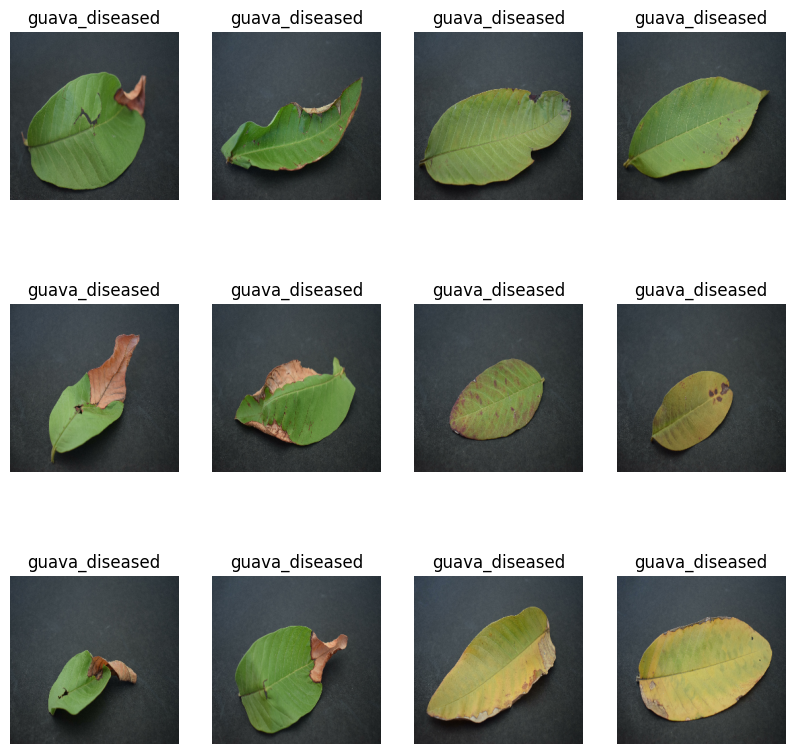

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [19]:
#data augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [20]:
#Applying data augmentation to the dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

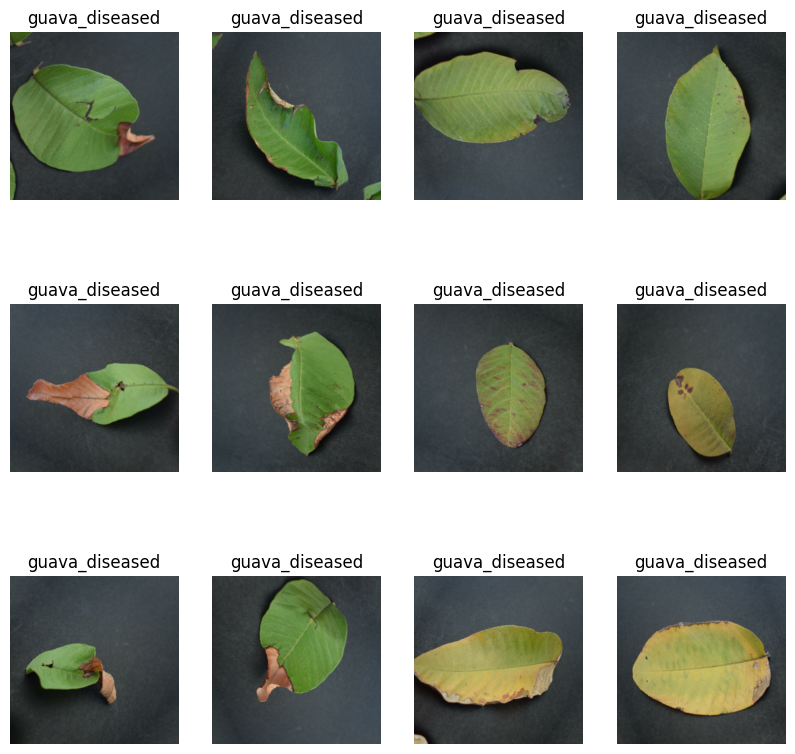

In [12]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
totalClasses = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(totalClasses, activation='softmax'),
])

model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (32, 123008)             

In [23]:
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30
57/57 [==============================] - 102s 2s/step - loss: 1.7688 - accuracy: 0.3662 - val_loss: 1.1110 - val_accuracy: 0.5536
Epoch 2/30
57/57 [==============================] - 41s 721ms/step - loss: 1.0709 - accuracy: 0.6135 - val_loss: 0.7815 - val_accuracy: 0.7277
Epoch 3/30
57/57 [==============================] - 42s 727ms/step - loss: 0.8552 - accuracy: 0.6913 - val_loss: 0.6703 - val_accuracy: 0.7812
Epoch 4/30
57/57 [==============================] - 41s 712ms/step - loss: 0.7433 - accuracy: 0.7297 - val_loss: 0.6006 - val_accuracy: 0.8080
Epoch 5/30
57/57 [==============================] - 40s 705ms/step - loss: 0.6406 - accuracy: 0.7610 - val_loss: 0.5623 - val_accuracy: 0.7902
Epoch 6/30
57/57 [==============================] - 42s 727ms/step - loss: 0.6190 - accuracy: 0.7747 - val_loss: 0.4089 - val_accuracy: 0.8527
Epoch 7/30
57/57 [==============================] - 42s 736ms/step - loss: 0.5459 - accuracy: 0.8010 - val_loss: 0.4019 - val_accuracy: 0.8571
E

In [25]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 26s 135ms/step - loss: 0.3121 - accuracy: 0.8978


In [26]:
scores2 = model.evaluate(train_ds)

57/57 [==============================] - 17s 303ms/step - loss: 0.2272 - accuracy: 0.9084


In [27]:
scores3 = model.evaluate(val_ds)

7/7 [==============================] - 1s 151ms/step - loss: 0.3325 - accuracy: 0.8884


In [28]:
score4 = model.evaluate(dataset)

72/72 [==============================] - 34s 421ms/step - loss: 0.2842 - accuracy: 0.8953


In [29]:
scores

[0.31214383244514465, 0.897777795791626]

In [30]:
scores2

[0.22717326879501343, 0.9084429740905762]

In [31]:
scores3

[0.33246177434921265, 0.8883928656578064]

In [32]:
score4

[0.2842201590538025, 0.8952925801277161]

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

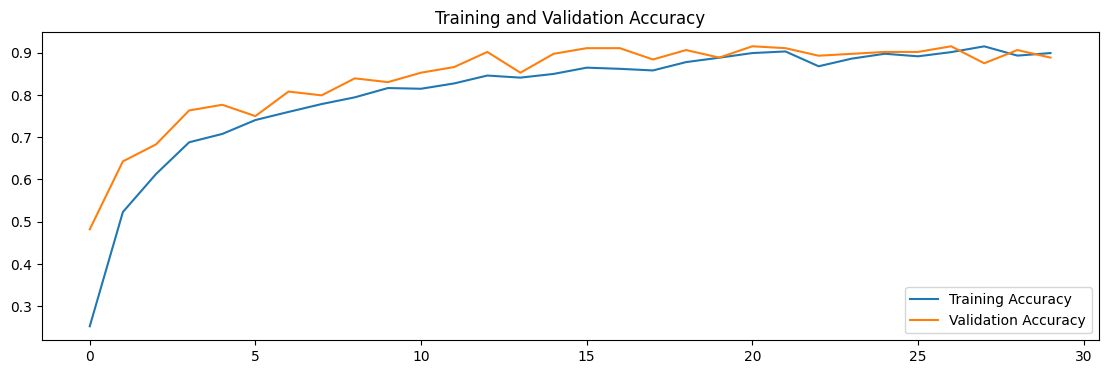

In [65]:
plt.figure(figsize=(30, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

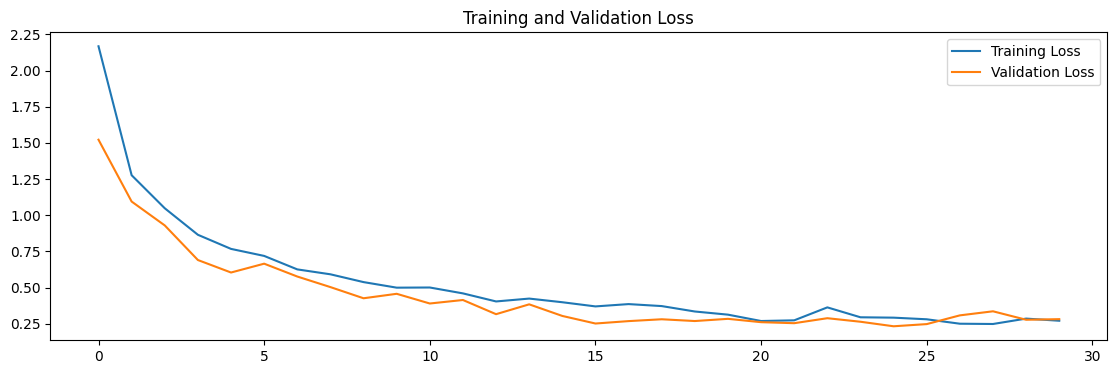

In [66]:
plt.figure(figsize=(30, 4))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: pomegrenate_healthy
1/1 [==============================] - 0s 212ms/step
predicted label: pomegrenate_healthy


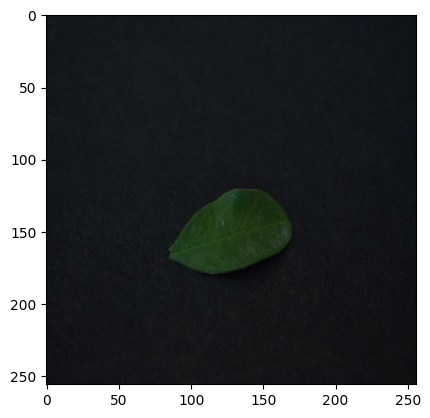

In [68]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [69]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 28ms/step


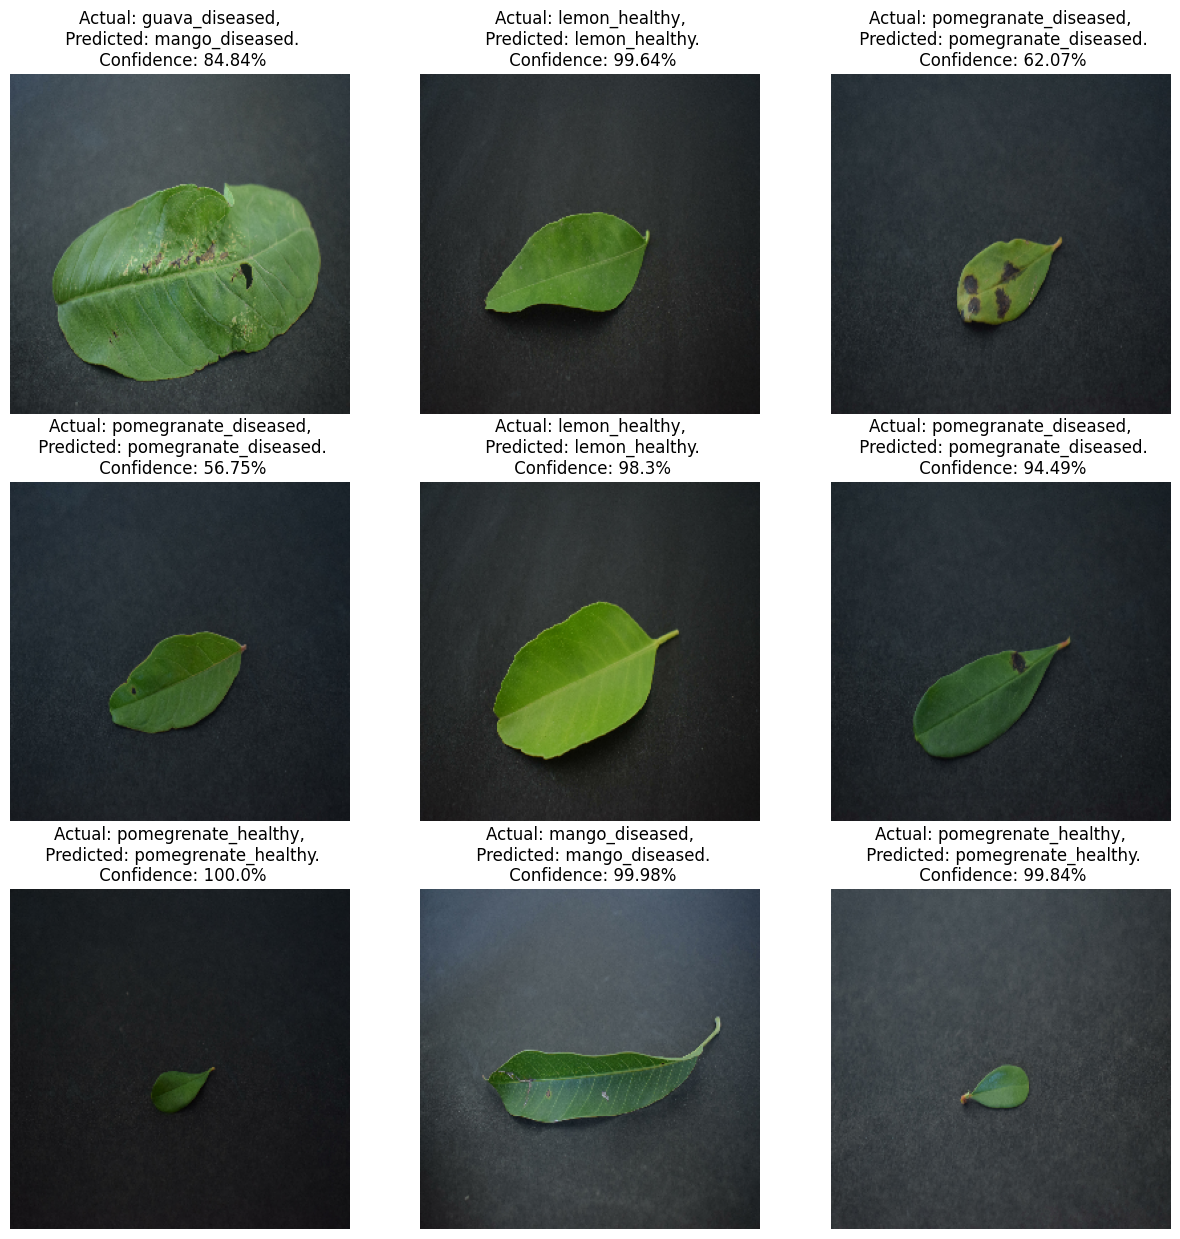

In [70]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [67]:
y_pred_prob = model.predict(test_ds)

8/8 [==============================] - 27s 134ms/step


In [70]:
#predicted probability
print(y_pred_prob)

[[1.0968069e-04 2.0839320e-01 2.2163038e-04 ... 4.8703691e-03
  7.6758319e-01 1.8656043e-02]
 [7.0059705e-12 8.2807375e-05 1.7683520e-08 ... 9.9991512e-01
  3.1256522e-07 1.0729005e-06]
 [3.1632021e-06 6.5797110e-07 7.7376467e-01 ... 2.3318048e-08
  1.5898199e-11 7.6770724e-18]
 ...
 [2.1862085e-11 5.2338978e-06 1.2925736e-07 ... 9.9974948e-01
  2.1861288e-06 6.1037140e-09]
 [3.5463920e-06 2.0244879e-05 6.0762238e-07 ... 9.7220290e-01
  1.0995040e-09 4.7312898e-10]
 [1.1333302e-09 1.8980498e-06 6.4025353e-06 ... 9.9752635e-01
  2.2538750e-05 1.7023187e-07]]


In [68]:
y_pred_labels = np.argmax(y_pred_prob, axis=1)

In [69]:
#predicted labels
print(y_pred_labels)

[8 7 2 9 1 6 9 7 1 5 8 2 6 6 6 0 8 1 6 2 7 2 9 3 1 3 6 6 1 1 2 1 8 6 5 4 0
 8 5 2 8 6 7 0 1 5 2 8 1 0 3 4 2 6 1 8 7 7 2 1 6 6 5 9 6 9 6 1 5 1 9 2 8 7
 3 2 9 5 8 9 2 3 0 2 3 2 1 3 6 3 1 2 1 6 2 6 3 0 1 7 6 2 7 2 8 9 2 1 3 8 1
 3 0 6 4 2 1 6 7 2 9 3 6 2 1 7 8 7 3 2 4 9 2 3 7 6 2 2 0 8 9 8 6 2 2 6 6 2
 9 0 0 6 9 2 2 7 9 3 9 0 5 3 7 6 2 2 6 2 2 8 1 3 9 7 9 0 0 2 9 3 8 5 9 1 9
 6 2 8 1 8 1 6 3 1 7 8 2 8 2 9 9 5 0 1 8 6 6 9 7 8 6 4 8 0 9 8 2 8 7 7 8 6
 7 7 7]


In [71]:
y_true_labels = np.concatenate([y for x, y in test_ds], axis=0)

In [72]:
#true labels
print(y_true_labels)

[9 7 2 9 1 6 9 7 1 5 9 2 6 6 6 0 9 1 6 2 7 2 9 3 1 1 6 6 1 1 0 1 8 3 5 5 0
 8 5 2 8 6 7 1 1 5 2 8 1 0 3 4 2 6 1 8 7 7 2 1 6 6 5 9 6 9 6 1 5 1 9 2 8 7
 3 2 9 5 8 9 2 3 0 2 3 2 1 3 6 3 1 2 1 6 2 6 3 0 1 7 6 2 7 2 9 9 3 1 3 8 1
 2 0 6 4 2 1 6 7 2 9 3 6 2 1 7 8 7 3 2 4 9 2 3 7 6 2 3 0 8 9 8 6 2 2 6 6 2
 9 3 1 6 9 2 2 7 9 3 9 0 5 3 7 0 2 2 6 2 2 8 1 3 9 7 9 0 0 2 9 3 8 5 9 1 9
 6 2 8 1 8 1 6 3 1 7 8 2 8 2 9 9 5 0 1 8 6 6 9 7 8 6 4 8 1 9 8 2 8 7 7 8 6
 7 7 7]


In [73]:
cm = confusion_matrix(y_true_labels, y_pred_labels)

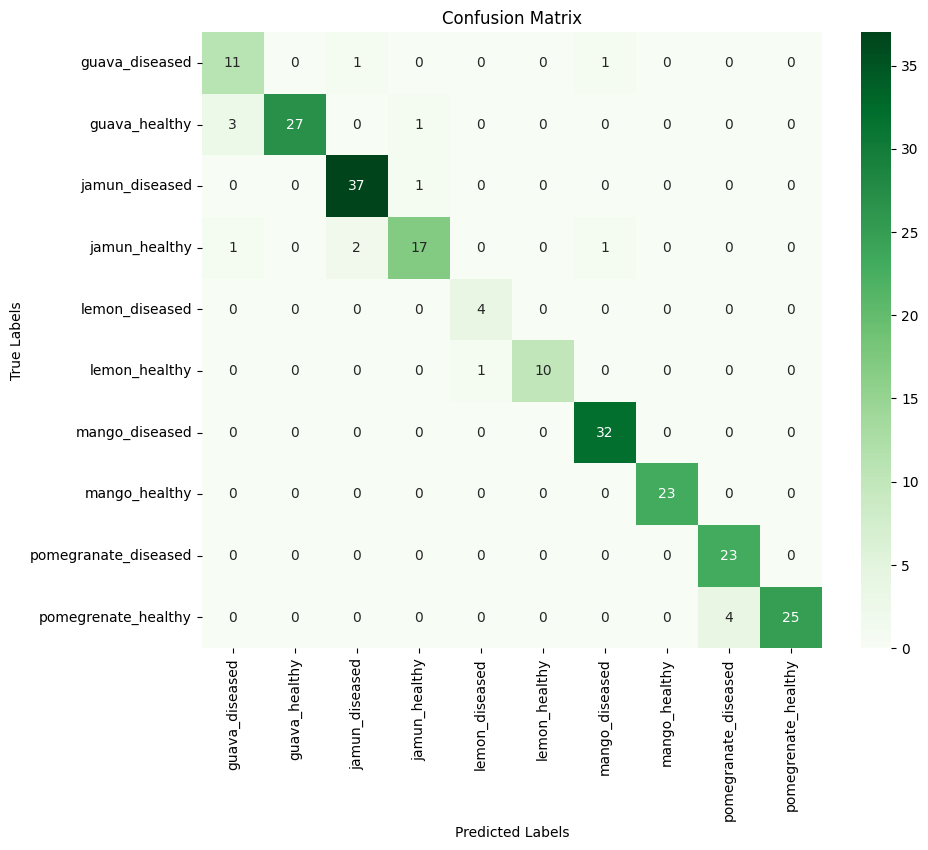

In [74]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Greens", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [77]:
def calculate_accuracy(confusion_matrix):
    diagonal_sum = np.trace(confusion_matrix)
    total_sum = np.sum(confusion_matrix)
    accuracy = diagonal_sum / total_sum
    return accuracy

accuracy = calculate_accuracy(cm)
print("Accuracy:", accuracy)

Accuracy: 0.9288888888888889


In [88]:
#predictions from the model
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

#true labels
y_true = np.concatenate([y for _, y in test_ds], axis=0)

#confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

#accuracy for each class
accuracy_per_class = []
for class_index in range(len(class_names)):
    TP = cm[class_index, class_index]
    TN = np.sum(np.delete(np.delete(cm, class_index, axis=0), class_index, axis=1))
    FP = np.sum(cm[:, class_index]) - TP
    FN = np.sum(cm[class_index, :]) - TP
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracy_per_class.append(accuracy)

# Print
for class_index, class_name in enumerate(class_names):
    print(f"Accuracy for class '{class_name}': {accuracy_per_class[class_index]}")


8/8 [==============================] - 1s 130ms/step
Accuracy for class 'guava_diseased': 0.9733333333333334
Accuracy for class 'guava_healthy': 0.9822222222222222
Accuracy for class 'jamun_diseased': 0.9822222222222222
Accuracy for class 'jamun_healthy': 0.9733333333333334
Accuracy for class 'lemon_diseased': 0.9955555555555555
Accuracy for class 'lemon_healthy': 0.9955555555555555
Accuracy for class 'mango_diseased': 0.9911111111111112
Accuracy for class 'mango_healthy': 1.0
Accuracy for class 'pomegranate_diseased': 0.9822222222222222
Accuracy for class 'pomegrenate_healthy': 0.9822222222222222


In [78]:
def calculate_specificity(confusion_matrix):
    true_negatives = confusion_matrix[0, 0]
    false_positives = confusion_matrix[0, 1]
    specificity = true_negatives / (true_negatives + false_positives)
    return specificity

specificity = calculate_specificity(cm)
print("Specificity:", specificity)

Specificity: 1.0


In [87]:
#predictions from the model
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

#true labels
y_true = np.concatenate([y for _, y in test_ds], axis=0)

#confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

#specificity for each class
specificity_per_class = []
for class_index in range(len(class_names)):
    TN = np.sum(np.delete(np.delete(cm, class_index, axis=0), class_index, axis=1))
    FP = np.sum(cm[:, class_index]) - cm[class_index, class_index]
    specificity = TN / (TN + FP)
    specificity_per_class.append(specificity)

# Print
for class_index, class_name in enumerate(class_names):
    print(f"Specificity for class '{class_name}': {specificity_per_class[class_index]}")


8/8 [==============================] - 1s 127ms/step
Specificity for class 'guava_diseased': 0.9811320754716981
Specificity for class 'guava_healthy': 1.0
Specificity for class 'jamun_diseased': 0.983957219251337
Specificity for class 'jamun_healthy': 0.9901960784313726
Specificity for class 'lemon_diseased': 0.995475113122172
Specificity for class 'lemon_healthy': 1.0
Specificity for class 'mango_diseased': 0.9896373056994818
Specificity for class 'mango_healthy': 1.0
Specificity for class 'pomegranate_diseased': 0.9801980198019802
Specificity for class 'pomegrenate_healthy': 1.0


In [79]:
def calculate_sensitivity(confusion_matrix):
    true_positives = confusion_matrix[1, 1]
    false_negatives = confusion_matrix[1, 0]
    sensitivity = true_positives / (true_positives + false_negatives)
    return sensitivity

sensitivity = calculate_sensitivity(cm)
print("Sensitivity:", sensitivity)

Sensitivity: 0.9


In [89]:
#predictions from the model
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

#true labels
y_true = np.concatenate([y for _, y in test_ds], axis=0)

#confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

#sensitivity for each class
sensitivity_per_class = []
for class_index in range(len(class_names)):
    TP = cm[class_index, class_index]
    FN = np.sum(cm[class_index, :]) - TP
    P = np.sum(cm[:, class_index])
    sensitivity = TP / (TP + FN)
    sensitivity_per_class.append(sensitivity)

# Print
for class_index, class_name in enumerate(class_names):
    print(f"Sensitivity for class '{class_name}': {sensitivity_per_class[class_index]}")


8/8 [==============================] - 1s 127ms/step
Sensitivity for class 'guava_diseased': 0.8461538461538461
Sensitivity for class 'guava_healthy': 0.8709677419354839
Sensitivity for class 'jamun_diseased': 0.9736842105263158
Sensitivity for class 'jamun_healthy': 0.8095238095238095
Sensitivity for class 'lemon_diseased': 1.0
Sensitivity for class 'lemon_healthy': 0.9090909090909091
Sensitivity for class 'mango_diseased': 1.0
Sensitivity for class 'mango_healthy': 1.0
Sensitivity for class 'pomegranate_diseased': 1.0
Sensitivity for class 'pomegrenate_healthy': 0.8620689655172413


In [80]:
def calculate_precision(confusion_matrix):
    true_positives = confusion_matrix[1, 1]
    false_positives = confusion_matrix[0, 1]
    precision = true_positives / (true_positives + false_positives)
    return precision

precision = calculate_precision(cm)
print("Precision:", precision)

Precision: 1.0


In [90]:
#predictions from the model
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

#true labels
y_true = np.concatenate([y for _, y in test_ds], axis=0)

#confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

#precision for each class
precision_per_class = []
for class_index in range(len(class_names)):
    TP = cm[class_index, class_index]
    FP = np.sum(cm[:, class_index]) - TP
    P = np.sum(cm[class_index, :])
    precision = TP / (TP + FP)
    precision_per_class.append(precision)

# Print
for class_index, class_name in enumerate(class_names):
    print(f"Precision for class '{class_name}': {precision_per_class[class_index]}")


8/8 [==============================] - 1s 129ms/step
Precision for class 'guava_diseased': 0.7333333333333333
Precision for class 'guava_healthy': 1.0
Precision for class 'jamun_diseased': 0.925
Precision for class 'jamun_healthy': 0.8947368421052632
Precision for class 'lemon_diseased': 0.8
Precision for class 'lemon_healthy': 1.0
Precision for class 'mango_diseased': 0.9411764705882353
Precision for class 'mango_healthy': 1.0
Precision for class 'pomegranate_diseased': 0.8518518518518519
Precision for class 'pomegrenate_healthy': 1.0


In [81]:
def calculate_f1_score(confusion_matrix):
    true_positives = confusion_matrix[1, 1]
    false_positives = confusion_matrix[0, 1]
    false_negatives = confusion_matrix[1, 0]
    
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

f1_score = calculate_f1_score(cm)
print("F1 Score:", f1_score)

F1 Score: 0.9473684210526316


In [91]:
#predictions from the model
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

#true labels
y_true = np.concatenate([y for _, y in test_ds], axis=0)

#confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

#F1 score for each class
f1_score_per_class = []
for class_index in range(len(class_names)):
    TP = cm[class_index, class_index]
    FP = np.sum(cm[:, class_index]) - TP
    FN = np.sum(cm[class_index, :]) - TP
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    f1_score_per_class.append(f1_score)

# Print
for class_index, class_name in enumerate(class_names):
    print(f"F1 score for class '{class_name}': {f1_score_per_class[class_index]}")


8/8 [==============================] - 1s 135ms/step
F1 score for class 'guava_diseased': 0.7857142857142856
F1 score for class 'guava_healthy': 0.9310344827586207
F1 score for class 'jamun_diseased': 0.9487179487179489
F1 score for class 'jamun_healthy': 0.8500000000000001
F1 score for class 'lemon_diseased': 0.888888888888889
F1 score for class 'lemon_healthy': 0.9523809523809523
F1 score for class 'mango_diseased': 0.9696969696969697
F1 score for class 'mango_healthy': 1.0
F1 score for class 'pomegranate_diseased': 0.92
F1 score for class 'pomegrenate_healthy': 0.9259259259259259


In [115]:
# data = tf.data.Dataset.from_tensor_slices((images, labels))
for image, labels in test_ds:
    arr = labels.numpy()
    arr_expanded = np.expand_dims(arr, axis=0)
    arr2 = np.concatenate(arr_expanded, axis = 0)
    print(arr2)

[5 7 2 0 8 5 7 4 1 8 1 6 6 6 0 9 4 1 8 2 2 1 3 5 3 9 7 6 3 5 3 3]
[3 2 3 7 0 9 1 8 1 1 2 2 1 0 6 1 9 5 6 7 1 3 2 2 7 9 5 9 9 3 9 9]
[8 9 1 7 8 6 9 2 8 7 1 5 6 6 6 3 2 2 2 3 5 0 1 5 3 0 1 9 3 1 8 8]
[5 3 2 1 8 8 3 3 6 1 2 7 0 6 2 2 1 1 4 6 3 2 3 3 0 6 7 1 3 3 5 3]
[9 0 2 2 5 7 2 3 2 4 3 3 2 4 2 6 8 8 4 3 9 2 4 9 2 4 6 8 9 9 3 2]
[2 2 2 4 6 5 5 6 6 1 2 1 1 1 6 9 5 9 6 8 1 6 8 3 3 0 0 2 2 2 0 6]
[6 1 2 3 7 6 0 6 7 1 8 9 1 9 1 2 7 5 0 0 1 6 2 9 3 1 5 6 8 3 8 3]
[3]


In [116]:
plabel = labels.numpy()
print(plabel)

[3]


In [117]:
predicted_probabilities = model.predict(test_ds)
print(predicted_probabilities)

8/8 [==============================] - 1s 130ms/step
[[6.8898307e-06 1.1908127e-02 7.3513645e-04 ... 2.3659992e-03
  5.5516102e-06 3.5501675e-12]
 [8.5496334e-14 1.1185771e-11 3.5484984e-10 ... 9.9999487e-01
  6.1729783e-15 8.9845530e-13]
 [1.3627467e-04 3.8923935e-03 6.2524283e-01 ... 2.4873841e-06
  5.8421901e-10 5.3864802e-11]
 ...
 [1.1526009e-05 4.2928813e-04 4.5154218e-05 ... 2.9311056e-04
  9.9778467e-01 5.6668714e-04]
 [2.2112286e-05 1.1723476e-04 7.6759271e-02 ... 2.7582233e-04
  2.5695124e-08 2.6183564e-09]
 [2.3043726e-04 3.5189551e-03 1.3410174e-02 ... 8.3206961e-04
  6.5307895e-06 1.2627146e-08]]


In [118]:
predicted_labels = np.argmax(predicted_probabilities, axis=1)
print(predicted_labels)

[5 7 2 6 8 5 7 4 1 9 1 6 6 6 0 9 5 1 8 2 3 1 3 5 2 9 7 6 3 5 3 3 3 2 3 7 0
 9 1 8 1 1 2 6 1 2 6 1 9 5 6 7 1 2 2 2 7 9 5 9 9 3 9 9 8 9 1 7 8 6 9 2 8 7
 1 5 6 6 6 2 2 2 2 3 5 0 1 5 3 0 1 9 3 1 8 8 5 3 2 7 8 8 3 2 6 1 0 7 3 6 3
 2 1 1 5 6 3 1 2 3 2 6 7 1 2 3 5 3 9 0 2 2 5 7 2 3 2 2 3 3 2 5 2 6 8 8 4 3
 9 2 7 9 2 5 6 8 9 9 1 3 2 2 2 4 6 5 5 6 6 1 2 1 1 1 6 9 5 9 6 8 1 6 8 3 3
 0 0 2 3 2 2 6 6 1 2 2 7 6 0 6 7 1 8 9 1 9 1 2 7 5 0 0 1 6 2 9 2 1 5 6 8 3
 8 3 3]
